# 1. BUSINESS PROBLEM
---

## 1.1. Context

The Rossmann company's CFO held a meeting with all store managers and asked each of them to bring a daily forecast for the next 6 weeks of sales.

After this meeting, all managers contacted you, requesting a sales forecast for your store.

**Note:** The data was made available [here](https://www.kaggle.com/c/rossmann-store-sales).

## 1.2. Understanding the problem

### 1.2.1. Motivation

The CFO requested this solution during a monthly results meeting.

### 1.2.2. Root cause of the problem

Difficulty in determining the investment value for renovations in each store.

### 1.2.3. Who is the Stakeholder

The Rossmann company's CFO.

### 1.2.4. Solution format

- Granularity and problem type: daily sales forecast in cash for the next 6 weeks;
- Potential resolution methods: Time Series, Regression, Neural Networks;
- Delivery format:
    1. The total sales amount at the end of 6 weeks;
    2. Possibility of checking the value by cell phone.

# 2. IMPORTS
---

## 2.1. Libraries

In [1]:
#!pip install -r requirements.txt

In [2]:
import math
import pickle
import random
import datetime
import inflection
import requests
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from scipy           import stats
from IPython.display import Image
from boruta          import BorutaPy
from flask           import request
from matplotlib      import pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

%matplotlib inline
plt.style.use('ggplot')

## 2.2. Helper Functions

In [3]:
def change_cols_to_snake_case(df):
    '''
    Change a list of columns of dataframe from 
    camel case to snake case.
    This function returns the modified dataframe.
    '''
    cols = df.columns
    snake_case = lambda x: inflection.underscore(x)
    new_cols = list(map(snake_case, cols))
    df.columns = new_cols
    return df

def check_nan_on_df_columns(df):
    '''
    Only check the NaN values on
    the dataframe columns.
    '''
    print(df.isna().sum())
    return None

def fillout_nan_on_col_with(time, col, df):
    '''
    According to "date" column on dataframe, this function fills NaN on certain attribute with
    the wanted time type. The time should be "year", "month" or "week".
    The function returns the modified dataframe.
    '''
    if time == 'year':
        df[col] = df.apply(lambda x: x['date'].year if math.isnan(x[col]) else x[col], axis=1)
        return df
    elif time == 'month':
        df[col] = df.apply(lambda x: x['date'].month if math.isnan(x[col]) else x[col], axis=1)
        return df
    elif time == 'week':
        df[col] = df.apply(lambda x: x['date'].week if math.isnan(x[col]) else x[col], axis=1)
        return df
    else:
        print('Unrecognized time...')
        return None

def get_num_cat_vars(df):
    '''
    Slice the dataframe in numerical and categorical variables.
    This function returns two dataframes, the first is containing the numerical
    attributes, the secound is containing the categorical attributes.
    '''
    num_attributes = df.select_dtypes(include=['int64', 'float64'])
    cat_attributes = df.select_dtypes(include=['object'])
    return num_attributes, cat_attributes
    
def show_histplot(x, data, title=None, xlabel=None, kde=True):
    '''
    Show the histplot, given a x, data, 
    title and x label values.
    '''
    plt.figure(figsize=(16, 8))
    sns.distplot(data[x])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

def plot_countplot_and_sales_kdeplot(var, df):
    '''
    Plot the countplot and sales kdeplot of a
    categorical variable side by side.
    '''
    var_values = df[var].unique()
    
    # Plotting the countplot of the variable
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.countplot(x=var, data=df)
    
    # Plotting the sales kdelplot of each 
    # value on the variable
    plt.subplot(1, 2, 2)
    for value in var_values:
        sns.kdeplot(df[df[var] == value]['sales'], 
                    label=value, shade=True)
    plt.suptitle(f'{var} count and sales kde plot given this variable',
                 fontsize=16)
    plt.legend()
    plt.show()

def group_sales_by(variables, df):
    '''
    Just group the sales by some variables on a given list
    and return the modified dataframe.
    '''
    vars_with_sales = ['sales']
    
    for var in variables:
        vars_with_sales.append(var)
        
    aux_df = df[vars_with_sales].groupby(variables).sum().reset_index()
    return aux_df

def show_barplot(x, y, df, rotation=None, size=None, palette=None, title=None):
    '''
    Show a simple barplot.
    '''
    if size != None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(16, 8))
    if palette != None:
        sns.barplot(x=x, y=y, data=df, palette=palette)
    else:
        sns.barplot(x=x, y=y, data=df)
    if title == None:
        plt.title(f'{y} by {x}')
    else:
        plt.title(title)
    if rotation != None:
        plt.xticks(rotation=rotation)
    plt.show()

def give_sales_rank_palette(var, grouped_df, palette='Blues_d'):
    '''
    Order palette by sales values, given a variable. Return the 
    palette organized, just set in seaborn visualization function.
    '''
    hue_order = grouped_df.sort_values('sales', ascending=True)[var]
    hue_order.index = range(len(hue_order))

    palette = sns.color_palette(palette, len(hue_order))
    palette_hue_ordered = dict(zip(hue_order, palette))
    return palette_hue_ordered

def cramer_v(x, y):
    '''
    Take an x and y vectors and do the cramer's
    V test, to see the correlation between these values.
    Return the correlation.
    '''
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

    return v

def cyclical_transformation(variable, data, period):
    '''
    Transforming the respective period variable that has a cycle in sine and cossine.
    Return the new dataframe.
    '''
    data[f'{variable}_sin'] = data[variable].apply(lambda x: np.sin(x * (2 * np.pi / period)))
    data[f'{variable}_cos'] = data[variable].apply(lambda x: np.cos(x * (2 * np.pi / period)))
    
    data = data.drop(variable, axis=1)
    return data

def mean_absolute_percentage_error(y, yhat):
    '''
    Return the absolute error in percentage.
    '''
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    '''
    Make error scores related to y and y predicted.
    return a DataFrame with the errors.
    '''
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    '''
    Apply the time series cross-validation according to 6 weeks for validation fold.
    Return the dataframe with MAE, MAPE and RMSE averages and 2 times standard deviations.
    '''
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose == True:
            print('\nFold Number: {}'.format(k))
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta((k-1)*6*7)
        
        # Filtering the dataset by validation date
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # Training and validation datasets
        # Training:
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # Validation:
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # Model fitting
        m = model.fit(xtraining, ytraining)
        
        # Model prediction
        yhat = m.predict(xvalidation)
        
        # Performance
        m_results = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Store performances of each k fold iteration
        mae_list.append(m_results['MAE'])
        mape_list.append(m_results['MAPE'])
        rmse_list.append(m_results['RMSE'])
        
    # Mean of metrics
    mae_mean = np.round(np.mean(mae_list), 2).astype(str)
    mape_mean = np.round(np.mean(mape_list), 2).astype(str)
    rmse_mean = np.round(np.mean(rmse_list), 2).astype(str)

    # 2 * Standard Deviation of metrics
    mae_sd = np.round(np.std(mae_list), 2).astype(str)
    mape_sd = np.round(np.std(mape_list), 2).astype(str)
    rmse_sd = np.round(np.std(rmse_list), 2).astype(str)
        
    # Final results dataframe
    results = pd.DataFrame({'Model Name': model_name,
                            'MAE CV Mean ± SD': mae_mean + ' ± ' + mae_sd,
                            'MAPE CV Mean ± SD': mape_mean + ' ± ' + mape_sd,
                            'RMSE CV Mean ± SD': rmse_mean + ' ± ' + rmse_sd}, index=[0])
    
    return results

def mean_percentage_error(y, yhat):
    '''
    Return the mean percentage error.
    '''
    return np.mean((y-yhat)/y)

## 2.3. Loading Data

In [4]:
# Loading the sales df
df_sales = pd.read_csv('data/raw/train.csv', low_memory=False)
display(df_sales.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# Loading the store df
df_store = pd.read_csv('data/raw/store.csv', low_memory=False)
display(df_store.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Merging the sale and store df's
df = pd.merge(df_sales, df_store, how='left', on='Store')
display(df.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 3. DATA DESCRIPTION
---

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- `Id` - an Id that represents a (Store, Date) duple within the test set.

- `Store` - a unique Id for each store.

- `Sales` - the turnover for any given day (this is what you are predicting).

- `Customers` - the number of customers on a given day.

- `Open` - an indicator for whether the store was open. 
    - 0 = closed; 
    - 1 = open.

- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends: 
    - a = public holiday;
    - b = Easter holiday;
    - c = Christmas;
    - 0 = None.

- `SchoolHoliday` - indicates if the (Store, Date) was affected by the closure of public schools.

- `StoreType` - differentiates between 4 different store models: a, b, c, d.

- `Assortment` - describes an assortment level:
    - a = basic;
    - b = extra;
    - c = extended.

- `CompetitionDistance` - distance in meters to the nearest competitor store.

- `CompetitionOpenSince[Month/Year]` - gives the approximate year and month of the time the nearest competitor was opened.

- `Promo` - indicates whether a store is running a promo on that day.

- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 
    - 0 = store is not participating;
    - 1 = store is participating.

- `Promo2Since[Year/Week]` - describes the year and calendar week when the store started participating in Promo2.

- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started a new. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

## 3.1. Rename Columns

I'll rename the camel case columns to snake case in this section. Because my programming style is with snake case.

In [7]:
# Showing the old columns
print('Old columns:')
print(df.columns, '\n')

Old columns:
Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object') 



In [8]:
# Changing columns to snake case
print('New columns:')
df = change_cols_to_snake_case(df)
print(df.columns)

New columns:
Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


## 3.2. Data Dimensions

In [9]:
print(f'Number of rows: {df.shape[0]};')
print(f'Number of columns: {df.shape[1]}.')

Number of rows: 1017209;
Number of columns: 18.


## 3.3. Data Types

In [10]:
# Original data types
print(df.dtypes)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


Working with datetime type rather than object is easier! So, I'll change that!

In [11]:
# Changing the date type to datetime
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 3.4. Check NaN

In [12]:
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


There are a lot of NaN values on the last columns. It is highly recommended to fill that lines with some number, or at least, drop them, because we need to do this to run the machine learning algorithms in the future.

## 3.5. Fill out NaN

### 3.5.1. competition_distance

Maybe people haven't filled out this column because the distances to the nearest competitor store have not needed to be considered. In other words, the `competition_distance` of that store is too far!

Therefore, we only need to replace the NaN values for huge distances. The question is, what is a "huge distances"? 

Let's see the highest value on this column.

In [13]:
max_value = df['competition_distance'].max()
print(f'The max value of this attribute is: {max_value}.')

The max value of this attribute is: 75860.0.


So, we only need to replace the NaN for a huge distance, like... **200,000.0**.

In [14]:
df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


### 3.5.2. competition_open_since_month

Why this column has NaN? There are two reasons that I suppose:

1. The store doesn't have a nearest competitor, so there isn't an opening date;

2. There is a nearest competitor, but we don't know when is the opening date.

My solution to fill NaN on this column is to work with the actual month. I don't want to exclude this variable because it seems to be important to our analysis and maybe for machine learning algorithms...

In [15]:
df = fillout_nan_on_col_with('month', 'competition_open_since_month', df)

### 3.5.3. competition_open_since_year

The same logic above I'll apply to this attribute.

In [16]:
df = fillout_nan_on_col_with('year', 'competition_open_since_year', df)

In [17]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


Yep, we did it!

### 3.5.4. promo2_since_week

If the value is NaN on this column, it's because the store has not decided to participate on `promo2`. So, we don't know exactily what value to replace in this case, as well as the variables above!

Therefore, I'll replace the NaN with the current week, like the variables above.

In [18]:
df = fillout_nan_on_col_with('week', 'promo2_since_week', df)

### 3.5.5. promo2_since_year

The same logic above I'll apply to this attribute.

In [19]:
df = fillout_nan_on_col_with('year', 'promo2_since_year', df)

In [20]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64


### 3.5.6. promo_interval

To fill NaN values on this column, I think the best option is to replace with zeros. That is because maybe the `promo2` doesn't exist for that store, so we don't have any `promo_interval`!

In [21]:
df['promo_interval'].fillna(0, inplace=True)

In [22]:
# Checking if we did it right
check_nan_on_df_columns(df)

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64


Okay, we're almost done.

Look at the variable `promo_interval`. Maybe we can create another variable based on that, like if the current month of the store is on `promo2`! So, we can create an attribute called `is_promo` to signal this fact.

In [23]:
# Mapping the current number of the month to 3 first letter of the month
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr',
             5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug',
             9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

# Creating the month_map column, based on the map dict created above
df['month_map'] = df['date'].dt.month.map(month_map)
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul


In [24]:
# Creating the is_promo column
## If the promo_interval is 0, then do nothing
## Else the promo_interval has a string, then verify if the month_map is on that string
df['is_promo'] = df.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [25]:
# Looking to the final dataframe
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## 3.6. Change data types

On this section, I'll look to the columns type and make some modifications, maybe.

In [26]:
print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


We can see that `competition_open_since_month`, `competition_open_since_year`, `promo2_since_week` and `promo2_since_year` are float types, and the correct type of them is integer. let's change it!

In [27]:
wanted_cols = ['competition_open_since_month', 'competition_open_since_year', 
               'promo2_since_week', 'promo2_since_year']

for col in wanted_cols:
    df[col] = df[col].astype('int64')

print(df.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


## 3.7. Descriptive Statistics

Before we start, I want to separate the numerical and categorical variables, just because the analysis to these sets are different.

In [28]:
# Defining the numerical and categorical dfs
num_attributes, cat_attributes = get_num_cat_vars(df)

# Showing these dataframes
print('Numerical attributes:')
display(num_attributes)

print('Categorical attributes:')
display(cat_attributes)

Numerical attributes:


,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


Categorical attributes:


,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


Let's see how is the sales distribution and some statistics of the variables on numerical section and how is the categorical sales boxplots on categorical section.

### 3.7.1. Numerical Attributes

In [29]:
# Creating the metrics dataframe
metrics = num_attributes.describe().T.drop(['count', '25%', '75%'], axis=1)
metrics.rename({'50%' : 'median'}, inplace=True, axis=1)

# Creating the skewness and kurtosis of each variables
skews = num_attributes.apply(lambda x: x.skew()).T
kurtosis = num_attributes.apply(lambda x: x.kurtosis()).T

# Creating the range of min and max values
metrics['range'] = metrics['max'] - metrics['min']

# Adding the skews and kurthosis values on metrics dataframe
metrics['skew'] = skews
metrics['kurtosis'] = kurtosis

# Changing the index to a variable and renaming it
metrics.reset_index(inplace=True)
metrics.rename({'index':'attribute'}, axis=1, inplace=True)

# Changing the order of columns apresentation on dataframe
metrics = metrics[['attribute', 'min', 'max', 'range', 'mean', 'median', 
                   'std', 'skew', 'kurtosis']]
display(metrics)

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


Look at the `competition_open_since_year` variable. It has a high skew and kurtosis, and it's okay, because we fill out the 323,348 NaN with the current year. So, it doesn't matter.

One variable that catch our attention is the `competition_distance`, because it has the highest skew and kurtosis values. A conclusion for this is that most stores have a very near competitor.

Let's have a look at the `competition_distance` distribution.

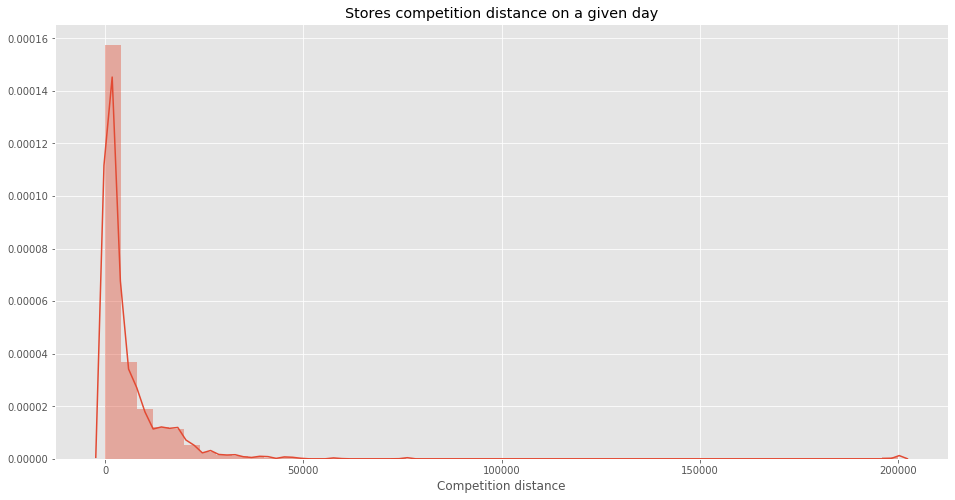

In [30]:
# Showing the stores competition distance count on a given day distribution
show_histplot('competition_distance', df, 
              'Stores competition distance on a given day', 
              'Competition distance')

Yep, it confirmed our theory.

Now, I want to see the stores sales distribution, our target for machine learning.

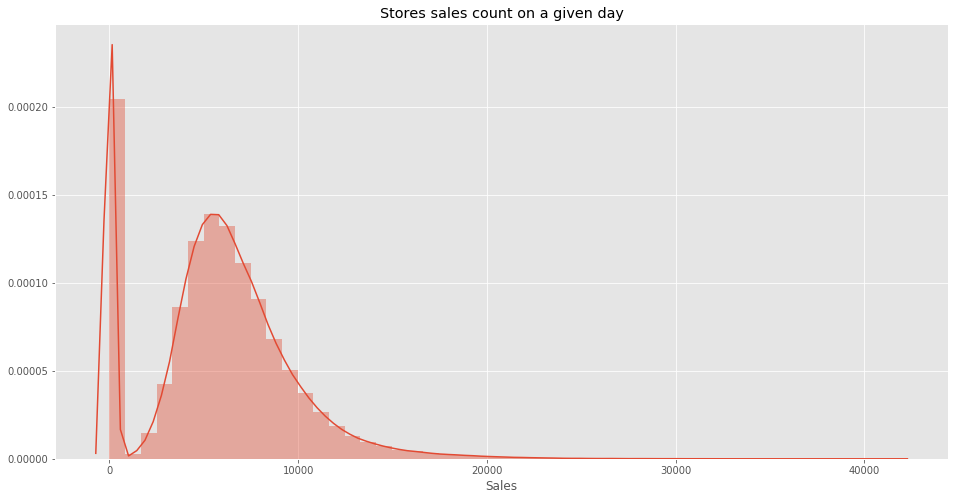

In [31]:
# Showing the stores sales count on a given day distribution
show_histplot('sales', df, 
              'Stores sales count on a given day', 
              'Sales')

The curve looks like a normal distribution, if we drop the zeros... Maybe, this is an important information.

### 3.7.2. Categorical Attributes

In [32]:
# Some conditions that I want to apply
aux_df = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]

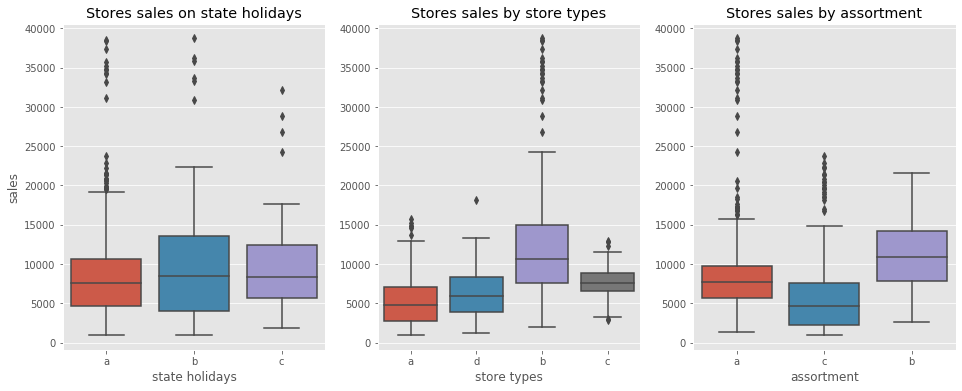

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.title('Stores sales on state holidays')
sns.boxplot(x='state_holiday', y='sales', data=aux_df)
plt.xlabel('state holidays')

plt.subplot(1, 3, 2)
plt.title('Stores sales by store types')
sns.boxplot(x='store_type', y='sales', data=aux_df)
plt.xlabel('store types')
plt.ylabel('')

plt.subplot(1, 3, 3)
plt.title('Stores sales by assortment')
sns.boxplot(x='assortment', y='sales', data=aux_df)
plt.ylabel('');

- The **state holiday**, **store type** and **assortment b** have the highest dispersions of stores sales;
- the **store type** and **assortment b** have the highest median of stores sales.

# 4. FEATURE ENGINEERING
---

## 4.1. Mind Map Hypothesis

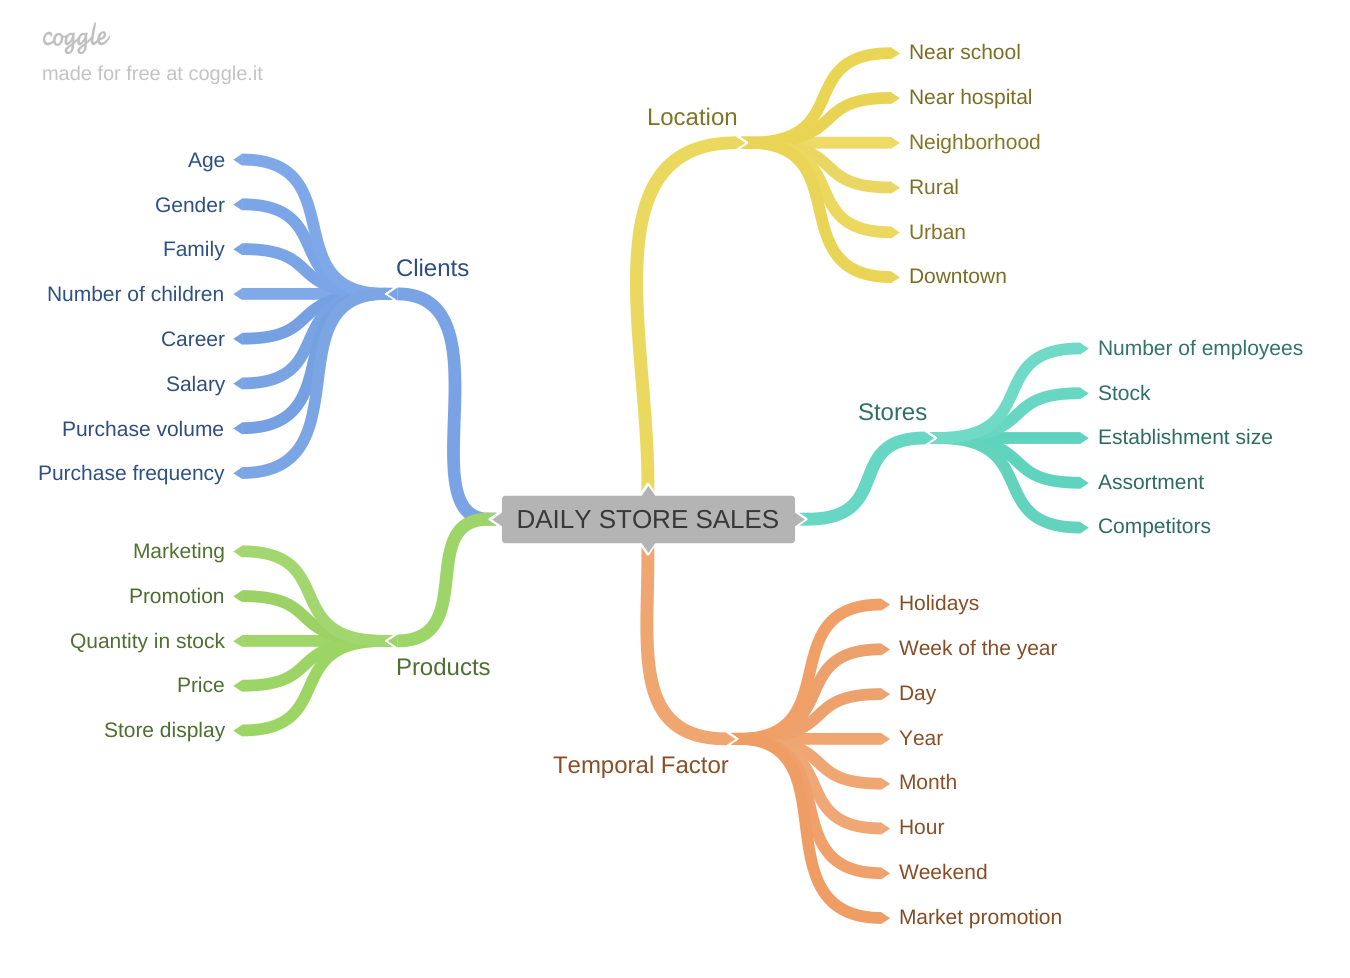

In [34]:
# Business mindmap
Image('img/mind_map_hypothesis.png')

## 4.2. Creating hypotheses

### 4.2.1. Store hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer-term competitors should sell more.

### 4.2.2. Product hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with products at a lower price should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with promotions actived for longer should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 4.2.3. Temporal hypothesis

**1.** Stores openning during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more before the 16th of each month (receiving people's salary).

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 4.3. Final hypothesis list

The criterion used here is if we have the data to answer the hypothesis. On the other hand, if we don't have them, we could ask for another sector of the company to get the new data, like marketing for example.

Basically, we analyse the data that we have now.

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with promotions actived for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores openning during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more before the 16th of each month (receiving people's salary).

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 4.4. Creating features

In [35]:
# Year
df['year'] = df['date'].dt.year

# Month
df['month'] = df['date'].dt.month

# Day
df['day'] = df['date'].dt.day

# Week of year
df['week_of_year'] = df['date'].dt.weekofyear

# Year week
df['year_week'] = df['date'].dt.strftime('%Y-%W')

# Before 16th variable
df['before_16th'] = df['day'].apply(lambda x: 'Yes' if x < 16 else 'No')

In [36]:
# Competition since ("Year-Month-01" format)
df['competition_since'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                  month=x['competition_open_since_month'], 
                                  day=1), axis=1)

# Competition time month
## First we catch the number of months between the competition_since and the "current" date
## Next we apply the dt.days method to catch the "number of days", i.e. the number of months
## Finally we transform that datetime number in "int64"
df['competition_time_month'] = ((df['date'] - df['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# Promo since ("Year-Month-1" format)
df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str) # str transformation
df['promo_since'] = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)) # datetime transformation

# Promo time week (analogous to competition_time_month creation)
df['promo_time_week'] = ((df['date'] - df['promo_since'])/7).apply(lambda x: x.days).astype('int64')

In [37]:
# Renaming the columns below
## Assortment (a = basic | b = extra | c = extended)
df['assortment'] = df['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

## State Holiday (a = Public holiday | b = Easter holiday | c = Christmas | 0 = Regular day)
df['state_holiday'] = df['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [38]:
# Checking the new dataframe
df.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 5. VARIABLES FILTERING
---

Think with me, some variables we aren't going to have at the time of the sales prediction, it's a Business question!

We can put on the list:
- `customers`: we don't have this information on the future, so we can't put this on the algorithm.
- `open`: is this really necessary? If the store is closed (0), there aren't sales! But, on the other hand, we want the lines with `open` == 1. So, we only have to exclude the lines with `open` == 0 and after, exclude this variable.
- `sales`: only sales above 0 are really necessary!
- `promo_interval` and `month_map` we already have used this variable, to create others. But for the current moment, we don't need them!

Therefore, we have to filter these features!

## 5.1. Lines Filtering

In [39]:
# Filtering open and sales conditions
df = df[(df['open'] != 0) & (df['sales'] > 0)]

## 5.2. Columns Filtering

In [40]:
# Fitering open, customers, promo_interval and month_map columns
wanted_cols = ['open', 'customers', 'promo_interval', 'month_map']
df = df.drop(wanted_cols, axis=1)

In [41]:
# Checking the dataframe columns
print(df.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'before_16th', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')


# 6. EXPLORATORY DATA ANALYSIS (EDA)
---

## 6.1. Univariate analysis

### 6.1.1. Response variable

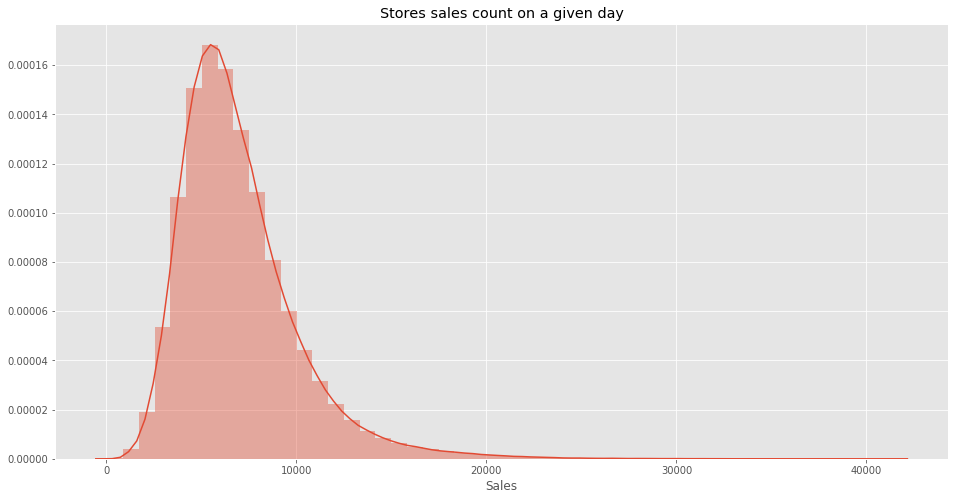

In [42]:
# Showing the stores sales count on a given day distribution
show_histplot('sales', df, 
              'Stores sales count on a given day', 
              'Sales', False)

Like we already said, the distribution looks like a normal curve, if we don't consider the zeros values.

### 6.1.2. Numerical variables

<ipython-input-43-52d9fa6e197a>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(ax=ax, bins=25);


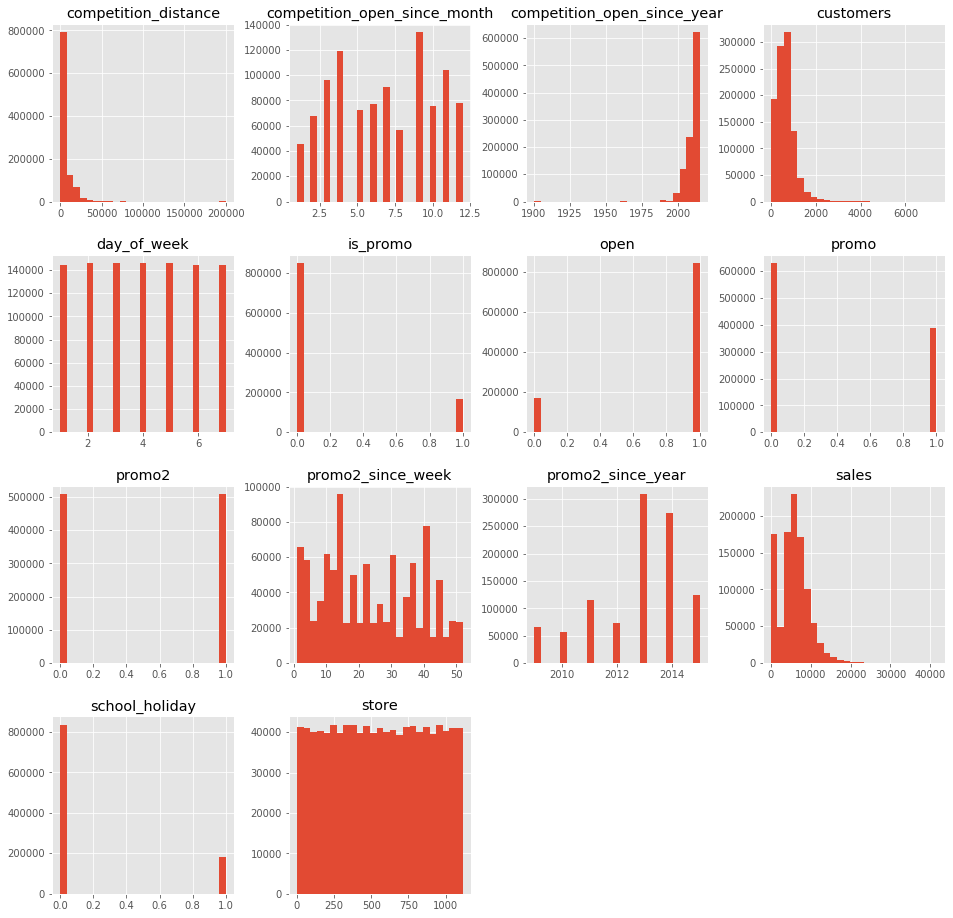

In [43]:
# Plotting all the histograms
fig, ax = plt.subplots(figsize=(16, 16))
num_attributes.hist(ax=ax, bins=25);

- Most stores were not affected by the closing of public schools.
- Most stores have a nearest competitor.
- The month in which the most store competitors opened was September, and in the second place is April.
- There is a high number of stores that started the `promo2` from 2013 onwards. Furthermore, the weeks of the year close to the fifteenth were the ones with the most stores in `promo2`.

### 6.1.3. Categorical variables

In [44]:
# Looking what are the categorical variables
print(cat_attributes.columns)

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')


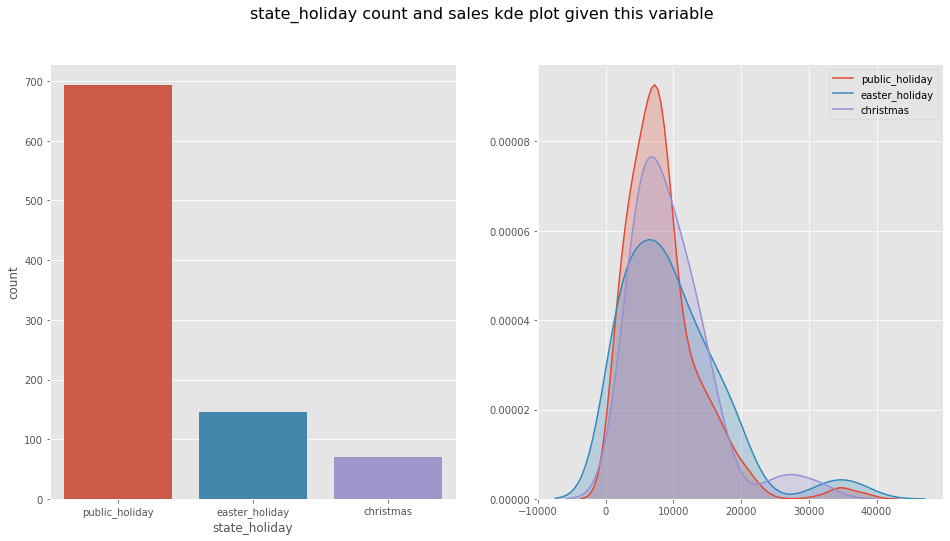

In [45]:
# state_holiday (without the regular_day)
aux_df = df[df['state_holiday'] != 'regular_day']
plot_countplot_and_sales_kdeplot('state_holiday', aux_df)

- Public holiday has the higher count of sales.
- Easter holiday has the higher dispersion of sales data, comparing to Public holiday and Christmas.

The volume and dispersion of sales are very different comparing the State holidays. So, this variable is going to be important for our ML model.

**Note:** I'm not considering the regular day because it is the majority, making it difficult to see the days that are holidays.

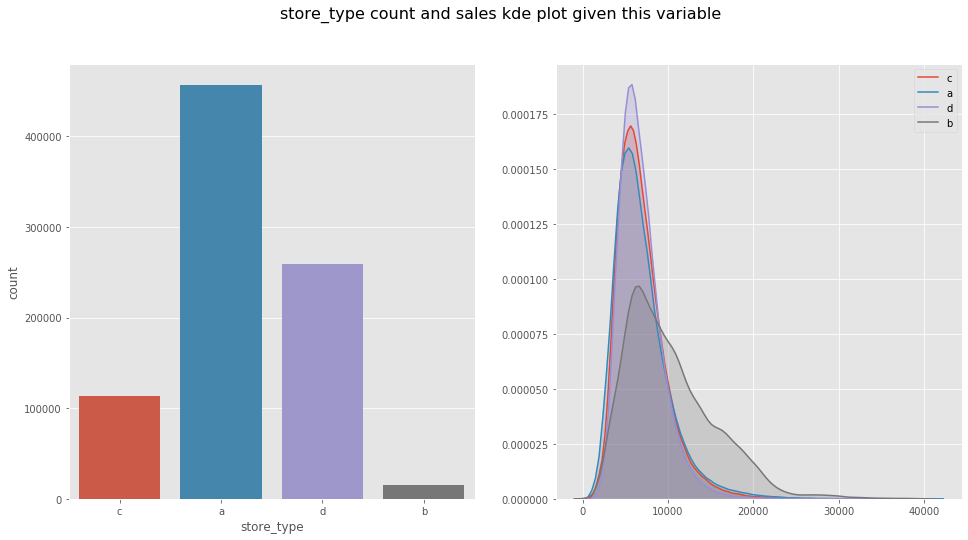

In [46]:
# store_type
plot_countplot_and_sales_kdeplot('store_type', df)

- "a" type has the higher count of sales.
- The sales count of the different types is very diverse.
- The dispersion of the "a", "c" and "d" are similar. The only different between these types are the heights of the peak on the density function.
- The higher dispersion is on "b" type. But, we have to remember that "b" has the lower count of sales, so, this is expected.

Again, this variable should probably be important for our models.

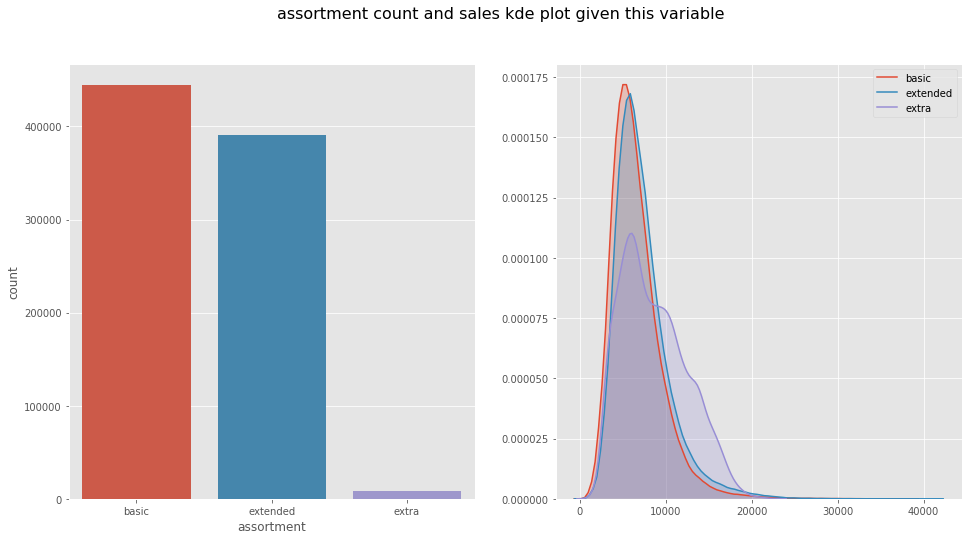

In [47]:
# assortment
plot_countplot_and_sales_kdeplot('assortment', df)

- "basic" and "extended" types have similar count of sales. On the other hand, "extra" type has lower quantity of sales.
- The sales distribution of "basic" and "extended" are similar, while "extra" type have a lower peak and a higher dispersion.

Again, this variable should probably be important for our models.

## 6.2. Bivariate analysis

### 6.2.1. $H_1$: Stores with a larger assortment should sell more.

**Answer: FALSE. Extra assortment stores sell less.**

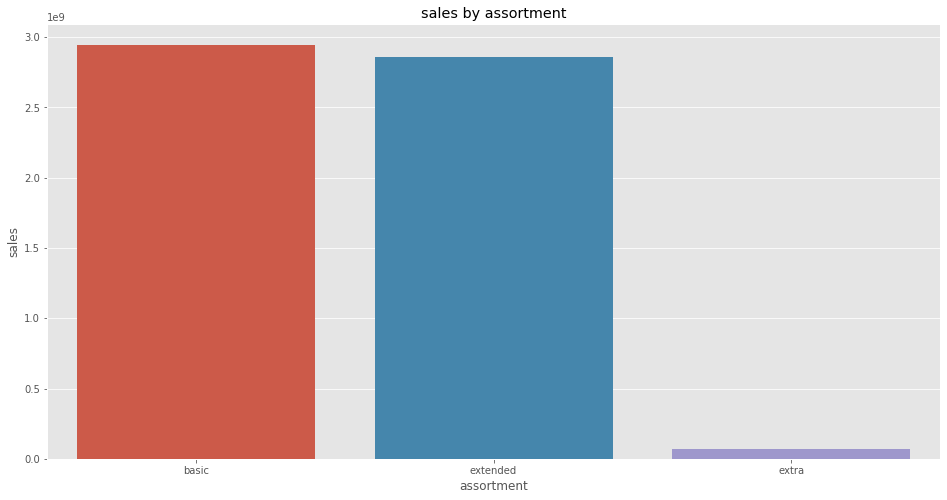

In [48]:
# Assortment sales df
assortment_df = group_sales_by(['assortment'], df)

# Barplot
show_barplot('assortment', 'sales', assortment_df)

It looks that **basic** assortment has the higher sum of sales, during the history. On the second place, we have the **extended** type. The extra has a very small sales volume, opposing our $H_1$ hypothesis!

However, this could be a wrong information, because we don't have the time factor! So, the sum of sales could be high on the past, and on the current moment, this isn't true anymore! Let's check this.

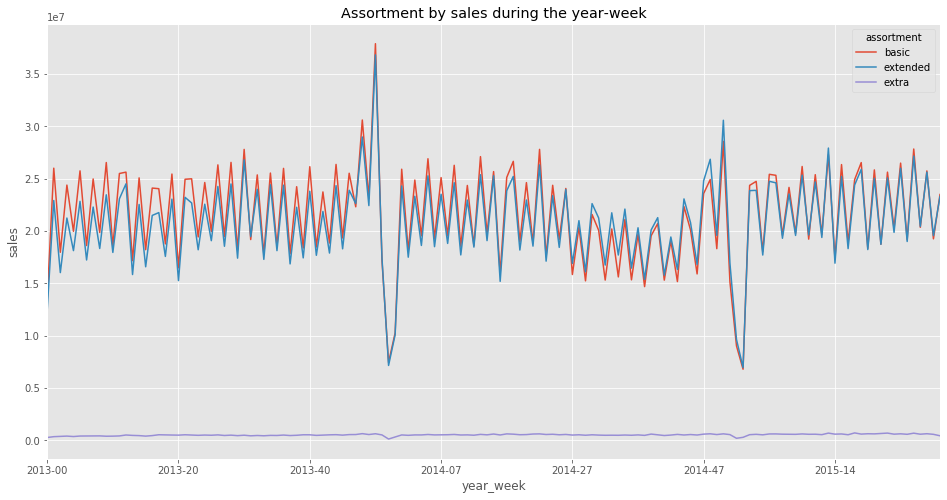

In [49]:
# Assortment year week sales df
assortment_yw_df = group_sales_by(['assortment', 'year_week'], df)

# Lineplot
assortment_yw_df.pivot(index='year_week', columns='assortment', 
                       values='sales').plot(figsize=(16, 8))
plt.title('Assortment by sales during the year-week')
plt.ylabel('sales');

Ok, now we are more confident in saying that $H_1$ is false, considering the time factor! To finish, let's look to the extra sales assortment separated, on a time scale.

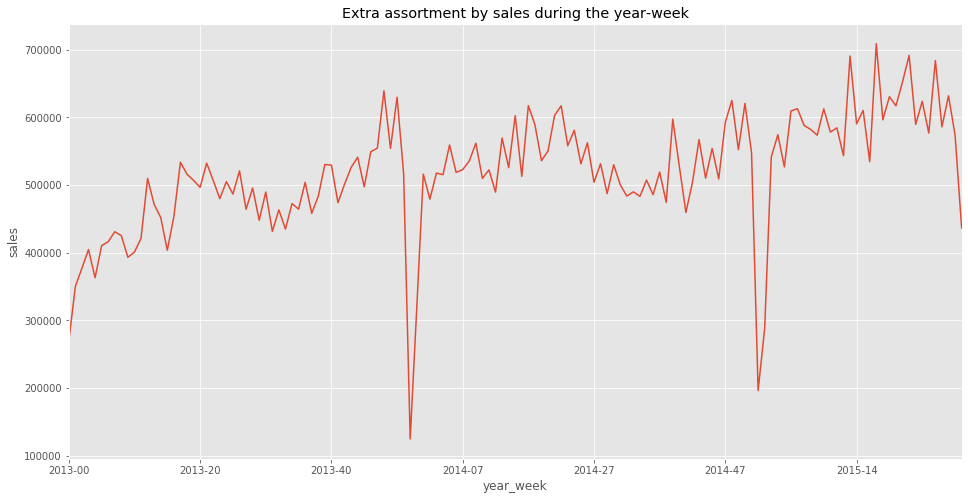

In [50]:
# Creating an extra assortment df
extra_df = assortment_yw_df[assortment_yw_df['assortment'] == 'extra'].drop('assortment', axis=1)
extra_df.index = extra_df['year_week']

# Lineplot
extra_df.plot(figsize=(16, 8), legend=False)
plt.title('Extra assortment by sales during the year-week')
plt.ylabel('sales');

It looks that extra assortment sales is growing up during the time!

### 6.2.2. $H_2$: Stores with closer competitors should sell less.

**Answer: FALSE. Stores with closer competitors sell more.**

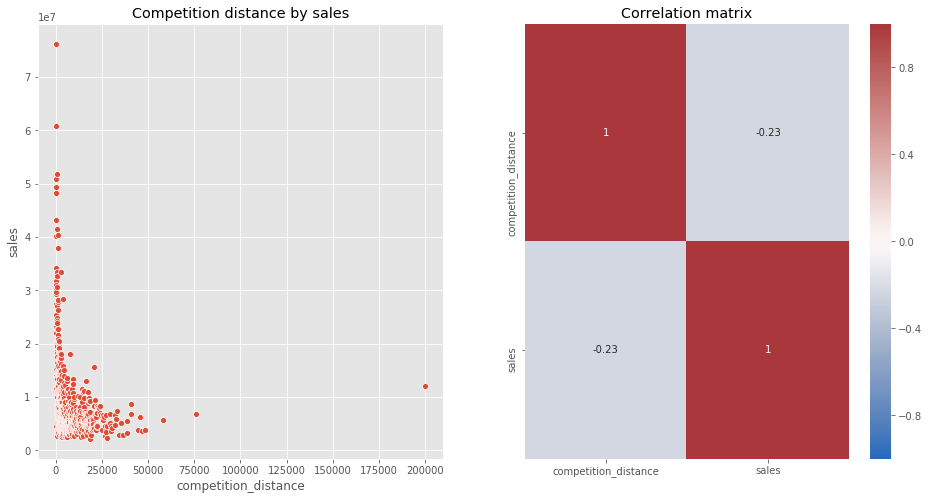

In [51]:
# Competition distance df
comp_dist_df = group_sales_by(['competition_distance'], df)

# Scatterplot
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=comp_dist_df)
plt.title('Competition distance by sales')

# Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(comp_dist_df.corr(method='pearson'), annot=True, 
            vmin=-1, vmax=1, cmap='vlag')
plt.title('Correlation matrix');

The sales data are concentrated on lower competition distances, and the higher values of sum of the sales too! Also, we know the Pearson's correlation, and this value is low.

Let's see sales in relation to the closest distances, that is, from 0 to 20,000 meters.

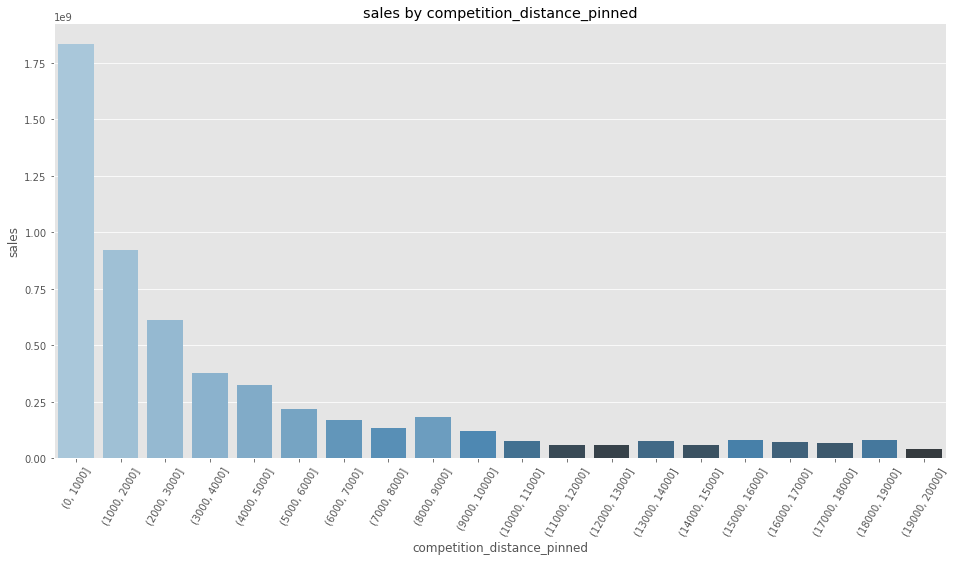

In [52]:
# Creating bins to view the competition_distance more easily
bins = list(np.arange(0, 20001, 1000))
comp_dist_df['competition_distance_pinned'] = pd.cut(comp_dist_df['competition_distance'], bins = bins)

# Competition distance pinned df
comp_dist_pin_df = group_sales_by(['competition_distance_pinned'], comp_dist_df)

# Barplot
palette = give_sales_rank_palette('competition_distance_pinned', comp_dist_pin_df)
show_barplot('competition_distance_pinned', 'sales', comp_dist_pin_df, 60, palette=palette)

The higher sum of sales is on the 0 to 1,000 meters interval! So, in a strange way, we can conclude that with more competition, more sales!

Therefore, the $H_2$ is false.

### 6.2.3. $H_3$: Stores with longer-term competitors should sell more.

**Answer: FALSE. Stores with longer-term competitors sell less.**

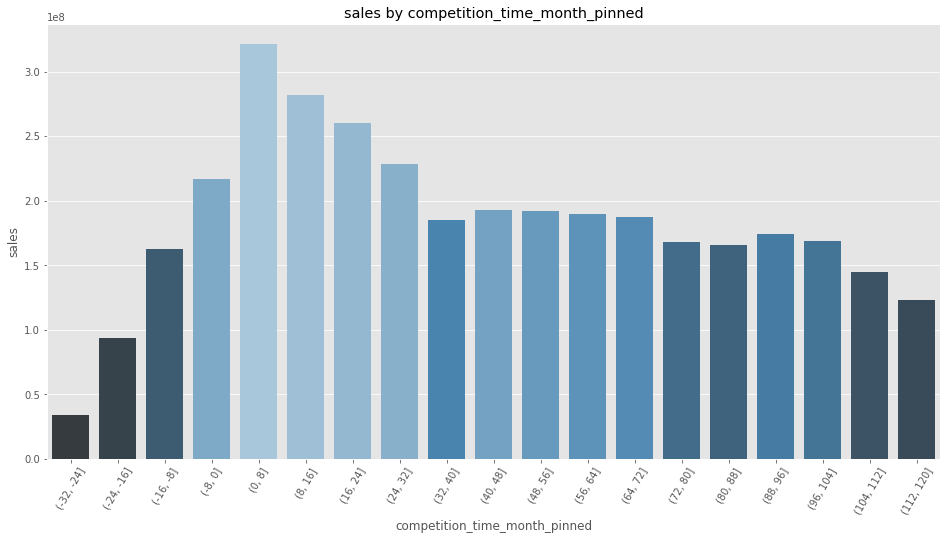

In [53]:
# Competition time month df (without time month equal to 0 and less than 120)
comp_time_m_df = group_sales_by(['competition_time_month'], df)
comp_time_m_df = comp_time_m_df[(comp_time_m_df['competition_time_month'] != 0) & (comp_time_m_df['competition_time_month'] <= 120)]

# Creating bins to view the competition_time_month more easily
bins = list(np.arange(-32, 121, 8))
comp_time_m_df['competition_time_month_pinned'] = pd.cut(comp_time_m_df['competition_time_month'], bins = bins)

# Competition distance pinned df
comp_time_m_pin_df = group_sales_by(['competition_time_month_pinned'], comp_time_m_df)

# Barplot
palette = give_sales_rank_palette('competition_time_month_pinned', comp_time_m_pin_df)
show_barplot('competition_time_month_pinned', 'sales', comp_time_m_pin_df, 60, palette=palette)

According to the graph above, we can see that the more recent the competition time (nearest to `competition_time_month` equal to zero), the greater the sum of sales in the grouped month periods! So, stores with longer-term competitors tend to sell less, thus shocking the hypothesis $H_3$.

**Note:** I've filtered the dataframe to view the barplot easily.

### 6.2.4. $H_4$: Stores with promotions actived for longer should sell more.

**Answer: FALSE. Promotions actived for longer tend to sell less.**

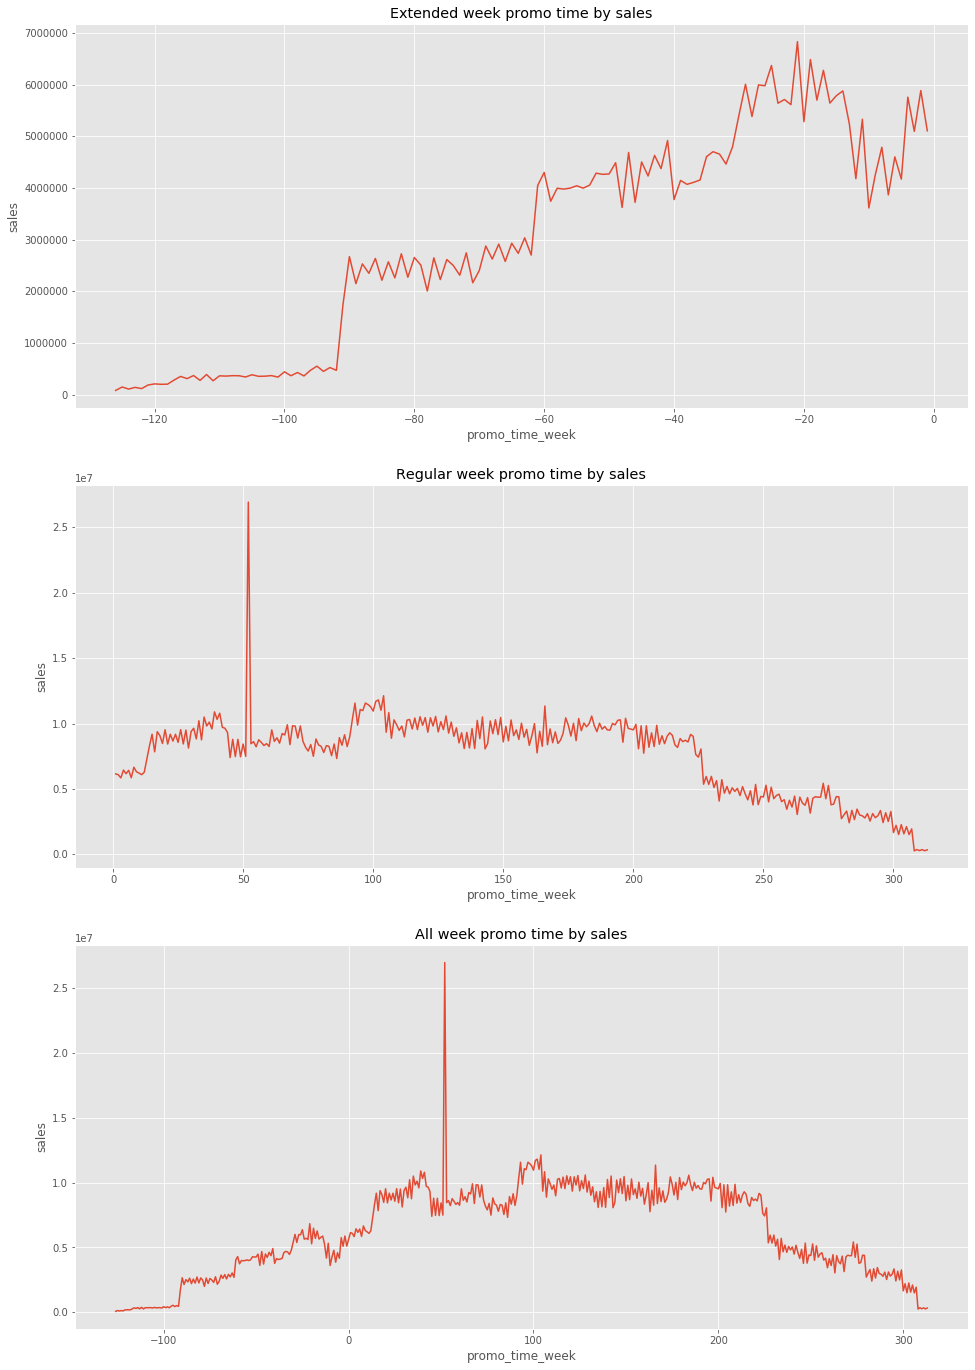

In [54]:
# Promo time week df
promo_time_w_df = group_sales_by(['promo_time_week'], df)

# Extended promo time week (< 0)
ext_df = promo_time_w_df[promo_time_w_df['promo_time_week'] < 0]

# Regular promo time week (> 0)
reg_df = promo_time_w_df[promo_time_w_df['promo_time_week'] > 0]

# Lineplots
plt.figure(figsize=(16, 24))

## Extended promo
plt.subplot(3, 1, 1)
sns.lineplot(x='promo_time_week', y='sales', data=ext_df)
plt.title('Extended week promo time by sales')

## Extended promo
plt.subplot(3, 1, 2)
sns.lineplot(x='promo_time_week', y='sales', data=reg_df)
plt.title('Regular week promo time by sales');

# All time promo
plt.subplot(3, 1, 3)
sns.lineplot(x='promo_time_week', y='sales', 
            data=promo_time_w_df[promo_time_w_df['promo_time_week'] != 0])
plt.title('All week promo time by sales');

**Notes:** 
- Week promo time = Current week - Promo week. So negative values means extended and positive means regular promo time.
- Extended week promo time: when promo week is on the future, i.e. we're going to have the `promo2` in a few weeks.
- Regular week promo time: when promo week have already started, i.e. we are in the `promo2` now.
- I've dropped zeros in promo_time_week because the sum of sales is very high, causing it to distort the line plot.

Looking at the first lineplot, we can conclude that `promo2` doesn't has high sum of sales in weeks far away. And if we have the `promo2` in approximately 90 weeks, the amount of sales starts to go up.

Looking at the second lineplot, we can conclude that sales remain constant for a period of approximately 225 weeks in `promo2`. After that, sales sales start to go down.

Therefore, the $H_4$ is false, because promotions actived for longer tend to sell less.

### 6.2.5. $H_5$: Stores with more promotion days should sell more.

**Answer: TRUE. More promotion days contribute in increasing the sales.**

In [55]:
# Promo days df
promo_days = df.groupby(['store'], as_index=False)[['promo', 'sales']].sum()

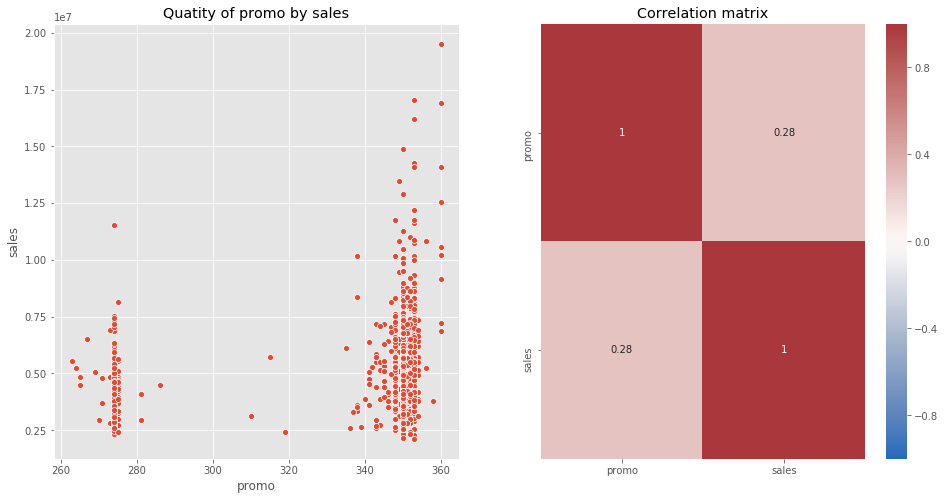

In [56]:
# Scatterplot
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x='promo', y='sales', data=promo_days)
plt.title('Quatity of promo by sales')

# Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(promo_days[['promo', 'sales']].corr(method='pearson'), annot=True, 
            vmin=-1, vmax=1, cmap='vlag')
plt.title('Correlation matrix');

### 6.2.6. $H_6$: Stores with more consecutive promotions should sell more.

**Answer: FALSE. Stores with more consecutive promotions sell less.**

In [57]:
# Promo df
promo_df = group_sales_by(['promo', 'promo2'], df)
display(promo_df)

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


The sum of sales doesn't have a huge change, comparing when we have consecutive promotions. 

Look at the line 3 of the dataframe above (when we have consecutive promotions), it has been sold 1,472,275,754. On the other hand, when we haven't had these promotions, we've sold more (1,482,612,096), and when we've had only the `promo`, we've had the higher number of sales (1,628,930,532)!

Let's take a look on these variables over the time.

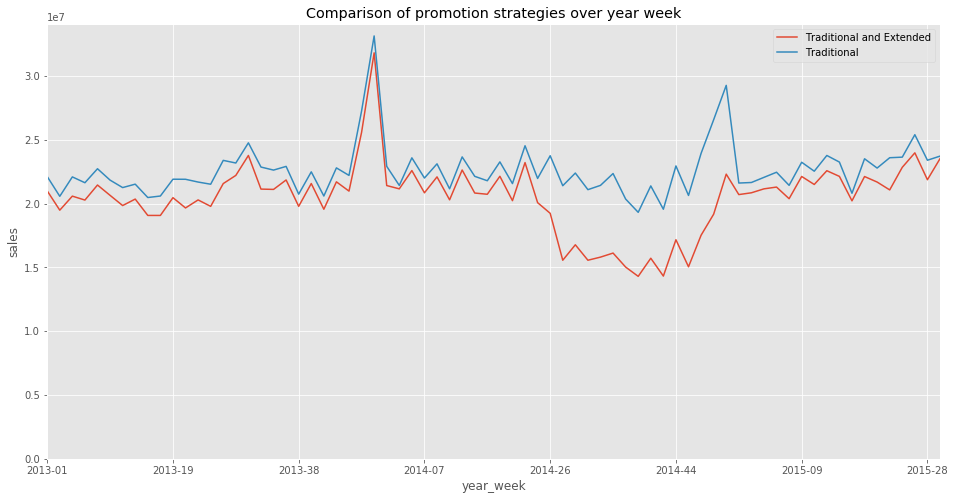

In [58]:
# All promo df
all_promo_df = df[(df['promo'] == 1) & (df['promo2'] == 1)]
all_promo_df = group_sales_by(['year_week'], all_promo_df)
all_promo_df.set_index('year_week', inplace=True)

# First promo df
fst_promo_df = df[(df['promo'] == 1) & (df['promo2'] == 0)]
fst_promo_df = group_sales_by(['year_week'], fst_promo_df)
fst_promo_df.set_index('year_week', inplace=True)

# Lineplot
ax = all_promo_df.plot()
fst_promo_df.plot(ax=ax, figsize=(16, 8))
ax.legend(labels=['Traditional and Extended', 'Traditional'])
plt.ylim(0)
plt.ylabel('sales')
plt.title('Comparison of promotion strategies over year week');

Yep, there were no big differences on promotion strategies over the time! In addition, traditional promotion only sold more every year week. Therefore, the $H_6$ is false.

### 6.2.7. $H_7$: Stores openning during the Christmas holiday should sell more.

**Answer: FALSE. Stores oppenning during the public holidays sell more, and not in Christmas.**

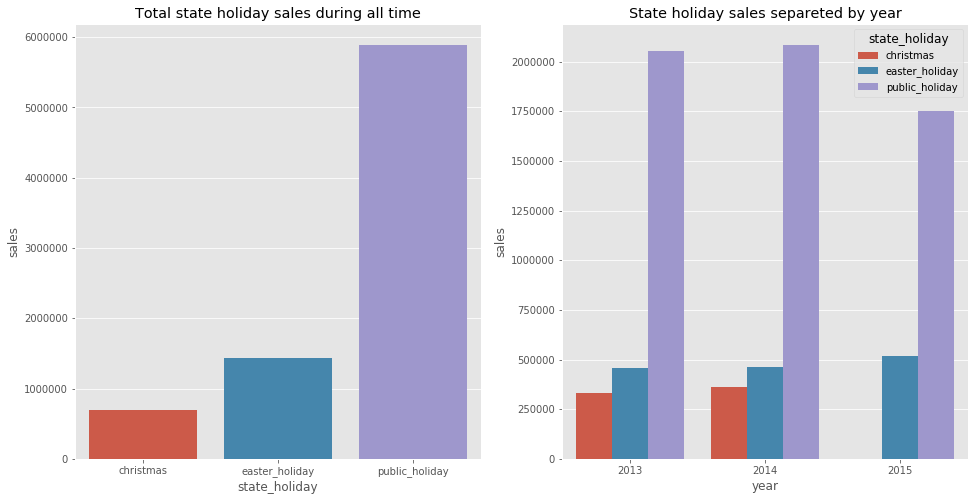

In [59]:
# State holiday df
state_holiday_df = df.query('state_holiday != "regular_day"')
state_holiday_df = group_sales_by(['state_holiday'], state_holiday_df)

# Time State holiday df
time_state_holiday_df = df.query('state_holiday != "regular_day"')
time_state_holiday_df = group_sales_by(['year', 'state_holiday'], 
                                       time_state_holiday_df)

# Barplots
plt.figure(figsize=(16, 8))
## State holiday
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', 
            data=state_holiday_df)
plt.title('Total state holiday sales during all time')

# Time State holiday
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', 
            data=time_state_holiday_df)
plt.title('State holiday sales separeted by year');

We don't have the Christmas on 2015 yet, but according to 2013 and 2014, we can conclude that most sales are done on public holidays, and not in Christmas! We can also include the time factor, it doesn't change anything! So $H_7$ is false.

### 6.2.8. $H_8$: Stores should sell more over the years.

**Answer: FALSE. Stores sell less over the years.**

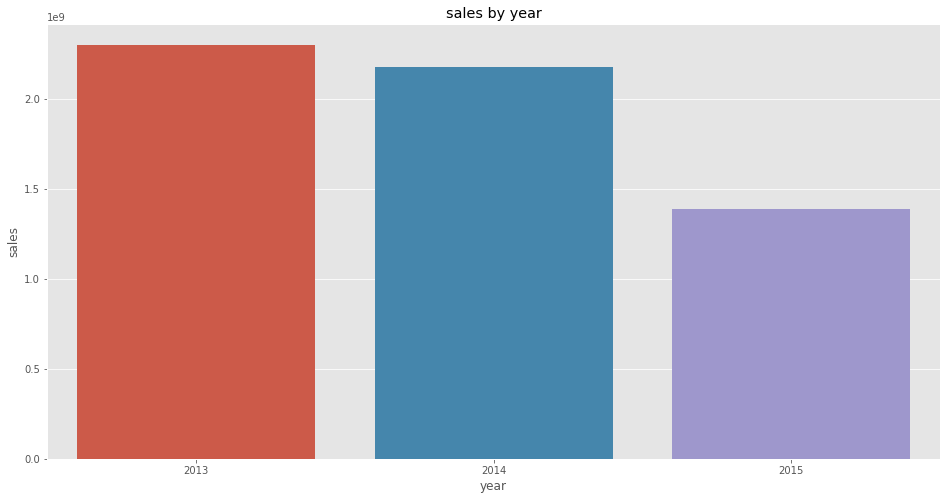

In [60]:
# Year sales df
year_sales_df = group_sales_by(['year'], df)

# Barplot
show_barplot('year', 'sales', year_sales_df);

Even not having Christmas, we can see that in 2013 and 2014 total sales have a negative trend, and in 2015 the trend may continue to be valid. So, over the years, if the stores continue in the same way, they maybe will no longer hold on in the future. Concluding, the $H_8$ is false.

### 6.2.9. $H_9$: Stores should sell more in the second half of the year.

**Answer: FALSE. Stores sell less in the second half of the year.**

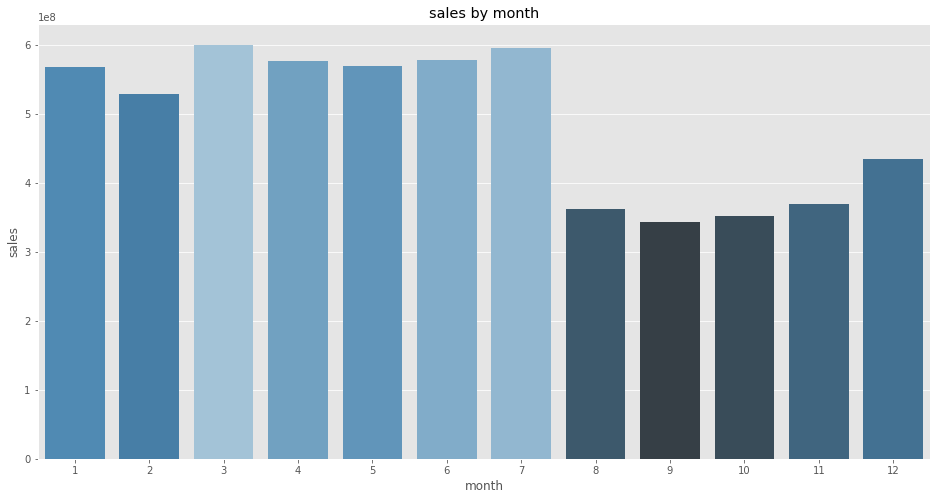

In [61]:
# Month sales df
year_sales_df = group_sales_by(['month'], df)

# Barplot
palette = give_sales_rank_palette('month', year_sales_df)
show_barplot('month', 'sales', year_sales_df, palette=palette);

The figure above is self explanatory! Stores sell less in the second half of the year, so $H_9$ is false.

### 6.2.10. $H_{10}$: Stores should sell more before the 16th of each month.

**Answer: FALSE. The sales are almost the same, comparing before the 16th day and after that.**

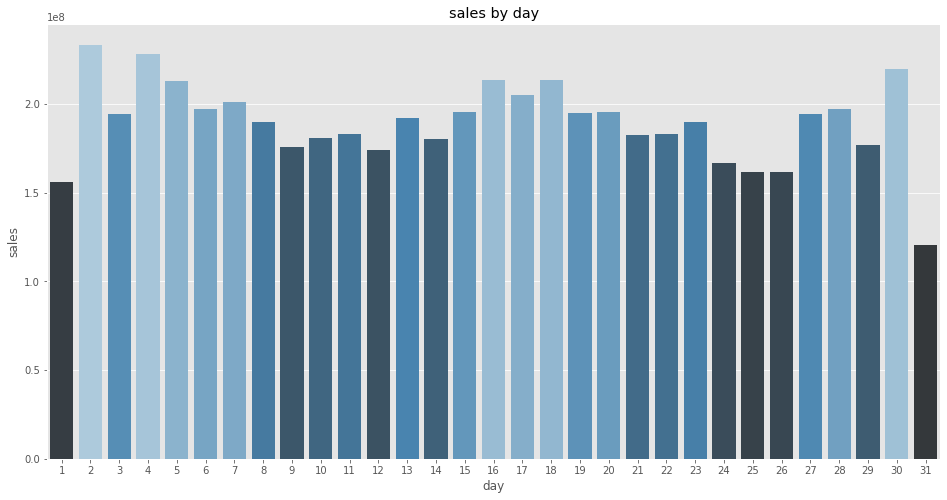

In [62]:
# Day sales df
day_sales_df = group_sales_by(['day'], df)

# Barplot
palette = give_sales_rank_palette('day', day_sales_df)
show_barplot('day', 'sales', day_sales_df, palette=palette);

Okay, we don't have a clear vision of the sales by 15th first days. But, we can conclude from this figure that:
- On first 5 days of the month, specifically on the 2nd, 4th and 5th days, stores sell more;
- In the midle of the month (16th, 17th and 18th), aproximately, stores sell good;
- On 30th day stores sell a lot too.

To find out if stores sell more before the 16th, I'll use the variable `before_16th`, indicating if the day is before the 16th day of the month and after that.

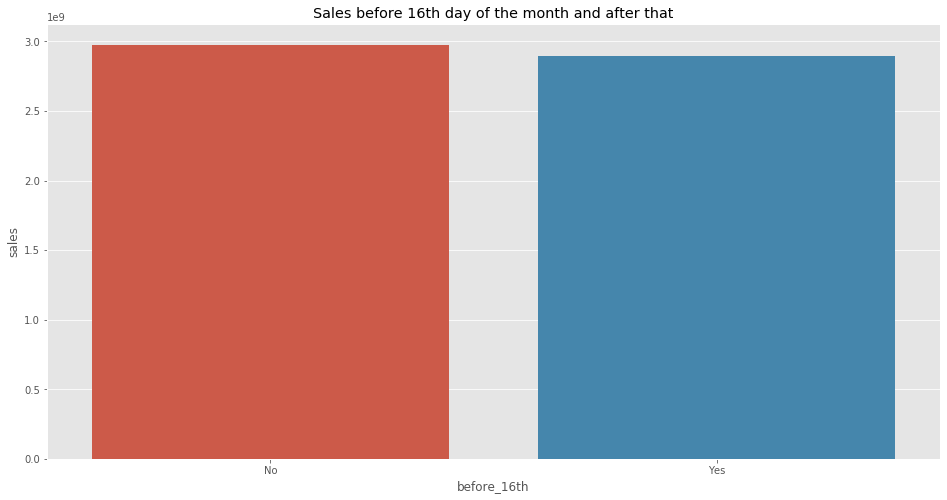

In [63]:
# Before after sales df
before_after_sales_df = group_sales_by(['before_16th'], df)

# Barplot
show_barplot('before_16th', 'sales', before_after_sales_df, 
             title='Sales before 16th day of the month and after that');

The sales are almost the same, comparing before the 16th day and after that! By the way, stores sell a little more after the 16th! So, $H_{10}$ is false.

### 6.2.11. $H_{11}$: Stores should sell less on weekends.

**Answer: TRUE. Stores sell less on weekends.**

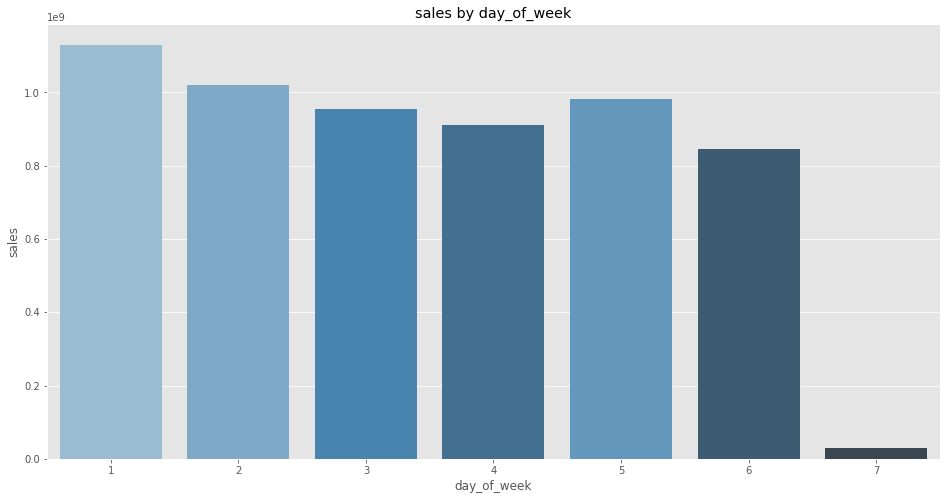

In [64]:
# days of week df
days_of_week_df = group_sales_by(['day_of_week'], df)

# Barplot
palette = give_sales_rank_palette('day_of_week', days_of_week_df)
show_barplot('day_of_week', 'sales', days_of_week_df, palette=palette)

According to the figure above, stores sell less on weekends. So finally, one hypothesis ($H_{11}$) is true.

### 6.2.12. $H_{12}$: Stores should sell less during school holidays.

**Answer: TRUE. Stores sell less during the school holidays, except on July and August.**

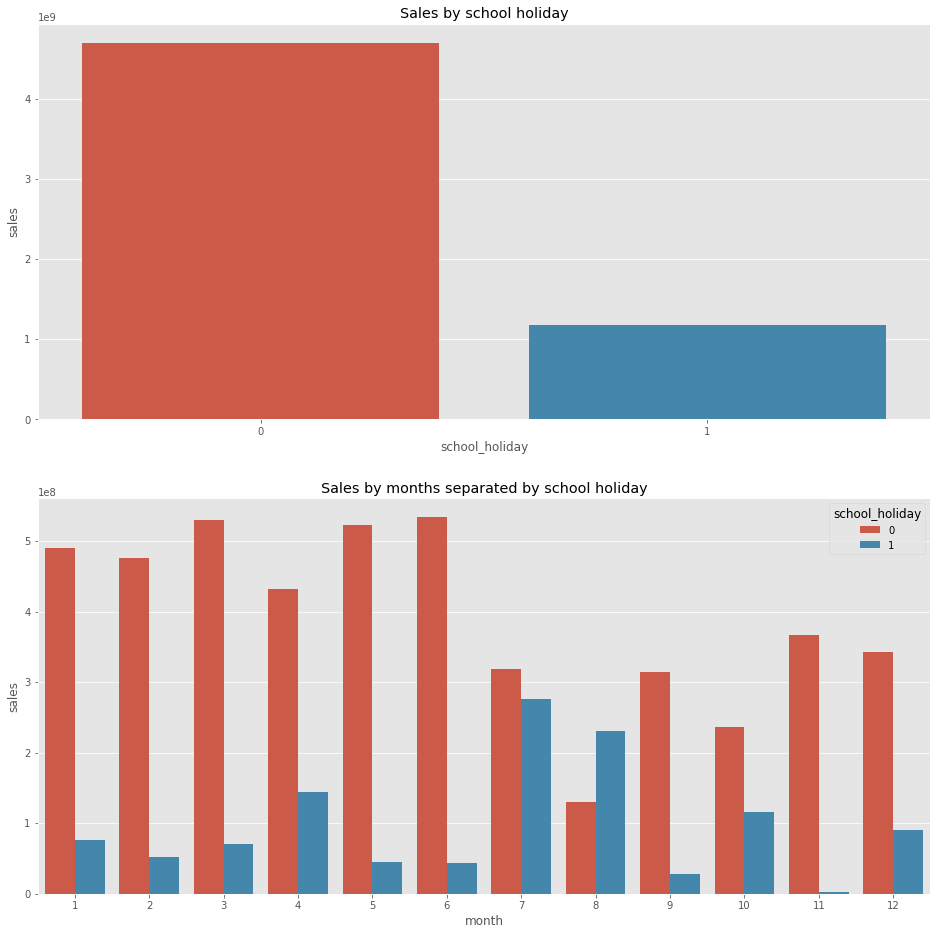

In [65]:
# School holiday df
school_holiday_df = group_sales_by(['school_holiday'], df)

# School holiday month df
school_holiday_m_df = group_sales_by(['month', 'school_holiday'], df)

# Barplots
## School holiday
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=school_holiday_df)
plt.title('Sales by school holiday')

## School holiday by month
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=school_holiday_m_df)
plt.title('Sales by months separated by school holiday');

Stores sell less during the school holidays, but on **July** and **August**, the sales stays almost equal and pass the regular day sales, respectively. I think this is because it's the mid-year school holidays for most schools. So, $H_{12}$ is true.

## 6.3. Multivariate analysis

This part will be important for feature selection, maybe.

In [66]:
# Getting updated num and cat attributes
num_attributes, cat_attributes = get_num_cat_vars(df)

### 6.3.1. Numerical attributes

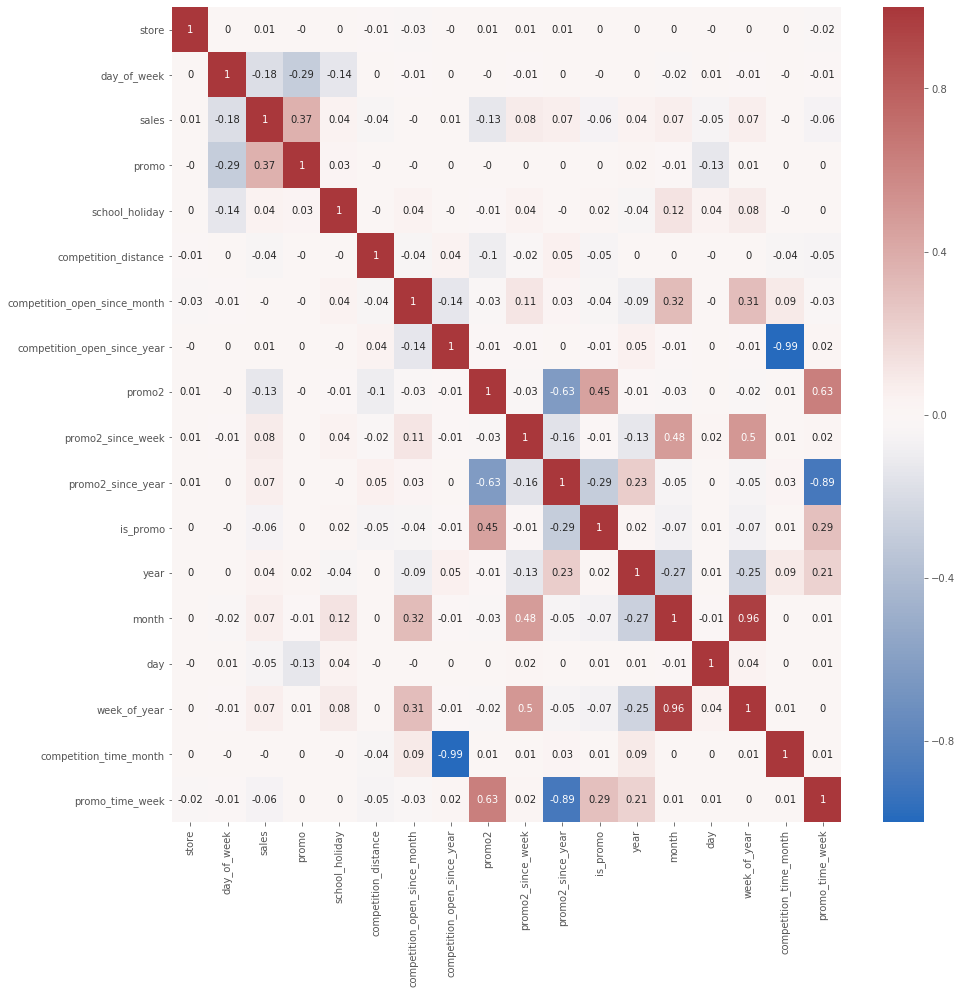

In [67]:
# Correlation matrix
corr = round(num_attributes.corr(method='pearson'), 2)

# Heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag');

### 6.3.2. Categorical attributes

In [68]:
# Creating the confusion matrix of cramer v values
wanted_columns = cat_attributes.columns.drop(['year_week', 'before_16th'])
cm = pd.DataFrame(columns=wanted_columns) # these variables are going to 
                                          # be excluded on the future

for col1 in wanted_columns:
    v_values = []
    for col2 in wanted_columns:
        v = cramer_v(cat_attributes[col1], cat_attributes[col2])
        v_values.append(v)
    cm[col1] = v_values
cm = cm.set_index(wanted_columns)

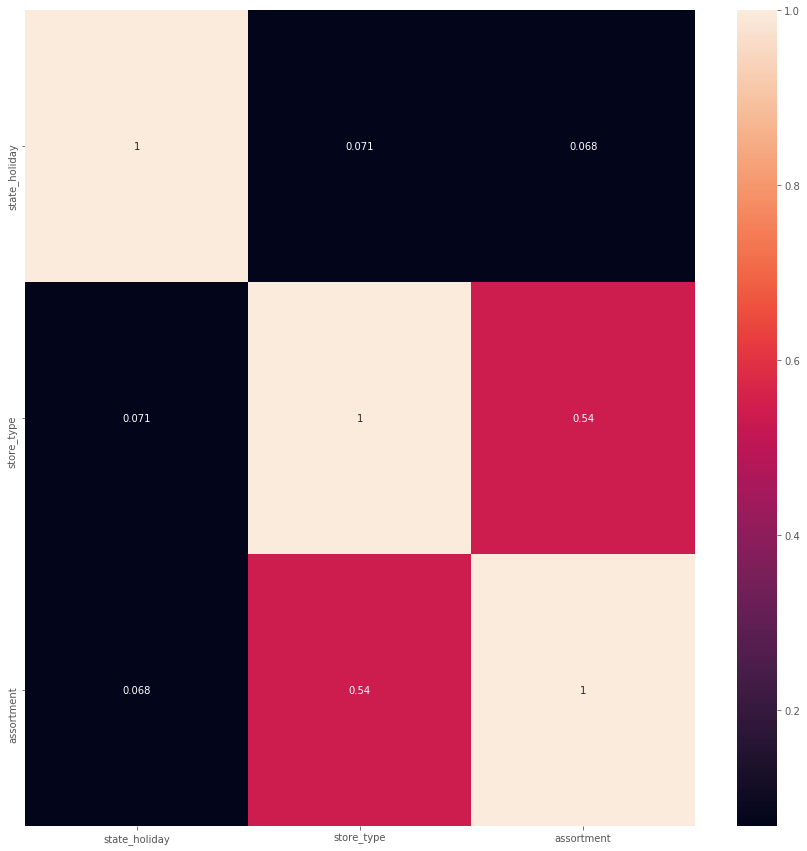

In [69]:
# Heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True);

# 7. DATA PREPARATION
---

## 7.1. Standardization

The `sales` variable looks like a normal distribution, but I really don't think that it is a good way standardizing it (I'm not absolutely sure it's normal). And the same thing for the others numerical attributes, even more that they don't look like a normal curve...

## 7.2. Rescaling

First, let's view the dataframe and decide which variable we'll use for rescaling. 

In [70]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


**Wanted variables:**
- `year`;
- `promo_time_week`.
- `competition_distance`;
- `competition_time_month`.

Now, I'll decide what technic I'll use to rescale these variables, using some boxplots and viewing if there are huge outliers.

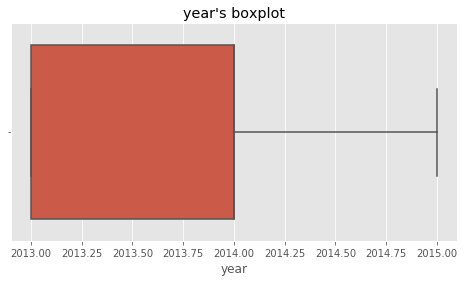

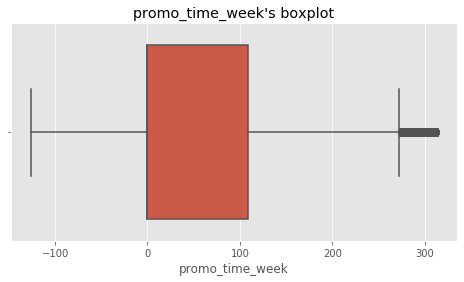

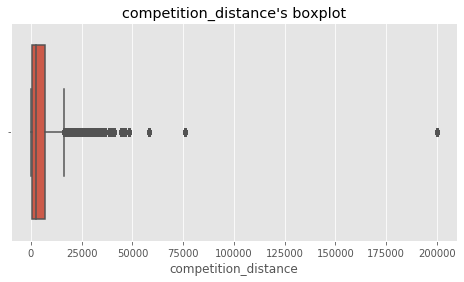

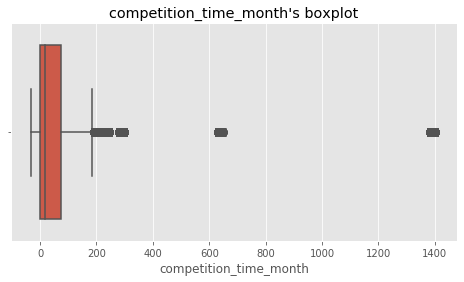

In [71]:
# Wanted variables
variables = ['year', 'promo_time_week', 
             'competition_distance', 'competition_time_month']

# Boxplots
for col in variables:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=col, data=num_attributes)
    plt.title(f"{col}'s boxplot")
    plt.show()

**Results:**

- ***Min Max Scaler:***
    - `year`;
    - `promo_time_week`.

- ***Robust Scaler:***
    - `competition_distance`;
    - `competition_time_month`.

Okay, let's apply these methods.

### 7.2.1. Min Max Scaler

In [72]:
mms = MinMaxScaler()

# year
df['year'] = mms.fit_transform(df[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# promo_time_week
df['promo_time_week'] = mms.fit_transform(df[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

### 7.2.2. Robusted Scaler

In [73]:
rs = RobustScaler()

# competition_distance
df['competition_distance'] = rs.fit_transform(df[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df['competition_time_month'] = rs.fit_transform(df[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

## 7.3. Transformation

### 7.3.1. Encoding

In [74]:
# Viewing again the categorical dataframe
cat_attributes.head()

,state_holiday,store_type,assortment,year_week,before_16th
0,regular_day,c,basic,2015-30,No
1,regular_day,a,basic,2015-30,No
2,regular_day,a,basic,2015-30,No
3,regular_day,c,extended,2015-30,No
4,regular_day,a,basic,2015-30,No


**Wanted variables to encode:**

- `state_holiday`;
- `store_type`;
- `assortment`.

In [75]:
# state_holiday - One Hot Encoding
df = pd.get_dummies(df, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df['store_type'] = le.fit_transform(df['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df['assortment'] = df['assortment'].map(assortment_dict)

In [76]:
df.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,year_week,before_16th,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,2015-30,No,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,2015-30,No,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,2015-30,No,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,2015-30,No,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,2015-30,No,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 7.3.2. Response Variable Transformation

I'll apply the logarithm transformation on the response variable, hoping for a a little change on the distribution, maybe something similar to normal.

In [77]:
df['sales'] = np.log1p(df['sales'])

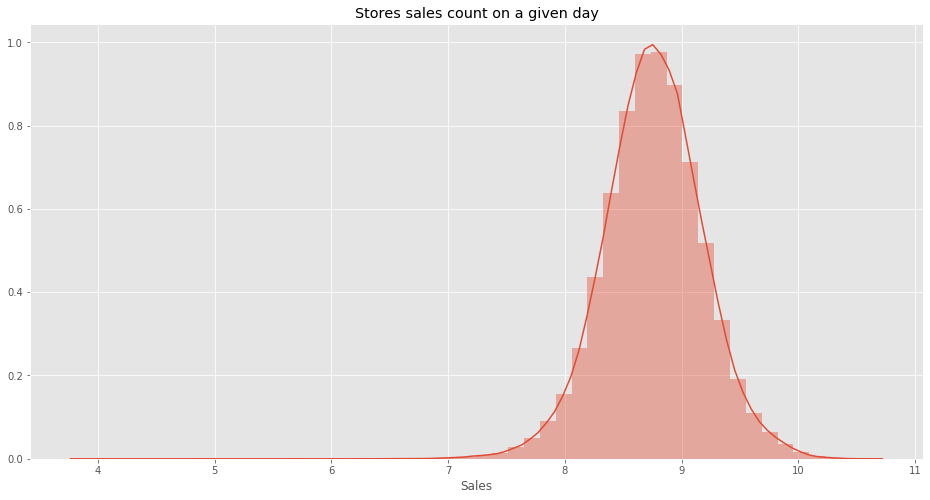

In [78]:
show_histplot('sales', df, 
              'Stores sales count on a given day', 
              'Sales', False)

### 7.3.3. Nature Transformation

On this section, I'll transform the cyclical variables in sine and cosine.

**Wanted variables:**

- `day_of_week`;
- `month`;
- `day`;
- `week_of_year`.

In [79]:
# day_of_week
df = cyclical_transformation('day_of_week', df, 7)

# month
df = cyclical_transformation('month', df, 12)

# day
df = cyclical_transformation('day', df, 30)

# week_of_year
df = cyclical_transformation('week_of_year', df, 52)

In [80]:
# Final dataframe
df.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 8. FEATURE SELECTION
---

Before we do anything, I'll drop some columns:
- `promo_since`, `competition_since`, `year_week` are date types, so they'll cause some problems to our ML models;
- `before_16th` is binary type, but it's a variable that doesn't give a new information (we have the `day_sin` and `day_cos` saying the same thing).

**Note:** I'll make some manipulations with `date` feature, so I'll drop this in the future.

In [81]:
cols_drop = ['promo_since', 'competition_since', 'year_week', 'before_16th']
df = df.drop(cols_drop, axis=1)

## 8.1. Spliting dataframe into training and testing dataset

To not cause overfitting, I'll split the test part with 6 weeks prior to last date, and the rest composing the training part.

In [82]:
# Showing the threshold date for the test part
six_weeks_date = df['date'].max() - datetime.timedelta(days=6*7)
print(six_weeks_date)

2015-06-19 00:00:00


In [83]:
# Training dataset
X_train = df[df['date'] < six_weeks_date]
y_train = X_train['sales']

# Testing dataset
X_test = df[df['date'] >= six_weeks_date]
y_test = X_test['sales']

In [84]:
# Showing the date of datasets
print('Training min date: {};'.format(X_train['date'].min()))
print('Training max date: {}.'.format(X_train['date'].max()))

print('\nTesting min date: {};'.format(X_test['date'].min()))
print('Testing max date: {}.'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00;
Training max date: 2015-06-18 00:00:00.

Testing min date: 2015-06-19 00:00:00;
Testing max date: 2015-07-31 00:00:00.


## 8.2. Boruta as feature selector

This section has a long time process... Maybe some hours to conclude.

In [85]:
# # Training and testing dataset for boruta
# X_train_n = X_train.drop(['sales', 'date'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

In [86]:
# # Define and fit boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
# boruta.fit(X_train_n, y_train_n)

**Best features from Boruta:**

In [87]:
# cols_selected = boruta.support_.tolist()

# # Best features
# X_train_fs = X_train.drop(['sales', 'date'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# # Not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [88]:
# print('Features selected by Boruta:')
# print(cols_selected_boruta)

In [89]:
# print('Features not selected by Boruta:')
# print(cols_not_selected_boruta)

Strangely, the algorithm has selected some cosine time variables, but they need to be in conjunction with the sine to make sense. So, let's inplace them in `cols_selected_boruta`.

## 8.3. Manual feature selection

In [90]:
# Adding respectively sine variables
cols_selected_boruta = [
    'store', 
    'promo', 
    'store_type', 
    'assortment', 
    'competition_distance', 
    'competition_open_since_month', 
    'competition_open_since_year', 
    'promo2', 
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month', 
    'promo_time_week', 
    'day_of_week_sin', 
    'day_of_week_cos', 
    'month_sin', #*
    'month_cos', 
    'day_sin', 
    'day_cos', 
    'week_of_year_sin', #*
    'week_of_year_cos'
]

In [91]:
# Final features
print('Final features:')
print(cols_selected_boruta)

Final features:
['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']


# 9. MACHINE LEARNING MODELLING
---

In [92]:
# Defining the x_train and x_test for a simple train test split (1 fold)
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

On this section, I'll be making a quick overview with a simple train-test split (1 fold) first, and after, I'll make a cross-validation of all models. But, before we start, I have to inplace the `date` and `sales` on X training dataset, because time series cross-validation require these variables.

**Note:** the `x_training` above is for time series, and the `x_train` and `x_test` are going to be used on simple train test split.

In [93]:
# Including the date and sales columns for cross-validation
cols_selected_boruta_full = cols_selected_boruta + ['date', 'sales']

# Time Series Data Preparation 
x_training = X_train[cols_selected_boruta_full]

## 9.1. Average Model 

I think that this model won't be chosen. But it's a nice parameter to compare to the others algorithms. That is, if the next models are worse than the average model, **don't use them**!

In [94]:
# Auxiliar dataframe 
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_results = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
display(baseline_results)

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 9.2. Linear Regression Model

In [95]:
# Model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_results = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
display(lr_results)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 9.2.1. Linear Regression - Cross Validation

In [96]:
lr_results_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
display(lr_results_cv)

,Model Name,MAE CV Mean ± SD,MAPE CV Mean ± SD,RMSE CV Mean ± SD
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37


## 9.3. Linear Regression Regularized Model

In [97]:
# Model -> alpha: arbitrary = 0.01
lrr = Lasso(alpha=0.01)
lrr.fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_results = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
display(lrr_results)

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 9.3.1. Lasso - Cross Validation

In [98]:
lrr_results_cv = cross_validation(x_training, 5, 'Lasso', lrr)
display(lrr_results_cv)

,Model Name,MAE CV Mean ± SD,MAPE CV Mean ± SD,RMSE CV Mean ± SD
0,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26


## 9.4. Random Forest Regressor 

Random Forest is so slower... I think that this model won't be chosen.

In [99]:
# Model
#rf = RandomForestRegressor(n_estimators=10,
#                           n_jobs=-1,
#                           random_state=42)
#rf.fit(x_train, y_train)

# Prediction
#yhat_rf = rf.predict(x_test)

# Performance
#rf_results = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#display(rf_results)

### 9.4.1. Random Forest Regressor - Cross Validation

In [100]:
#rf_results_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#display(rf_results_cv)

## 9.5. XGBoost Regressor

In [101]:
# Model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators=100,
#                             eta=0.01,
#                             max_depth=10,
#                             subsample=0.7,
#                             colsample_bytree=0.9)
#model_xgb.fit(x_train, y_train)

# Prediction
#yhat_xgb = model_xgb.predict(x_test)

# Performance
#xgb_results = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#display(xgb_results)

### 9.5.1. XGBoost Regressor - Cross Validation

In [102]:
#xgb_results_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#display(xgb_results_cv)

## 9.6. Compare Model's Performance

### 9.6.1. Single Performance

In [103]:
# Single performance dataframe
#modelling_results = pd.concat([baseline_results, lr_results, 
#                               lrr_results, rf_results, xgb_results])
#display(modelling_results.sort_values('RMSE'))

### 9.6.2. Real Performance - Cross Validation

In [104]:
# Real performance dataframe
#modelling_results_cv = pd.concat([lr_results_cv, lrr_results_cv, 
#                                  rf_results_cv, xgb_results_cv])
#display(modelling_results_cv.sort_values('RMSE CV Mean ± SD'))

I think that linear regression models don't fit well to the problem, because they are worst than the average algorithm on single performance... The XGBoost Regressor results are a little strange, they are so high... Maybe, this algorithm can bring lower values on fine tunning step. I'm not going to give up about this machine learning model.

XGBoost is better than Random Forest for me, because the XGB cost minus memory comparing to RF. The real objective is to put the model into production, then memory is an important threshold!

So, if we get better (or approximate) results than RF (metrics above) for XGB on Hyperparameter Fine Tunning, I'm going to use the XGBoost Regressor. If not, then Random Forest is the best option.

# 10. HYPERPARAMETER FINE TUNING
---

## 10.1. Random Search

 Random search have his problems, but I'll use this because it's the fastest way to choose some hyperparameters.

In [105]:
# Parameters
#params = {'n_estimators':[1500, 2000, 2500, 3000, 3500],
#          'eta':[0.01, 0.03],
#          'max_depth': [3, 5, 9],
#          'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytree': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]
#         } 

# Number of iterations on random search
#MAX_EVAL = 5

# final_results dataframe
#final_results = pd.DataFrame()

In [106]:
# Aproximately 9h to run this cell
# Commented because the run time is so long
#for i in range(MAX_EVAL):
    # Choose values for hyperparaters randomly
    #hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
    #model_string = f'XGBoost Regressor {i}'
    #print(f'{model_string}: {hp}')
        
    # Model
    #model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 #n_estimators=hp['n_estimators'],
                                 #eta=hp['eta'],
                                 #max_depth=hp['max_depth'],
                                 #subsample=hp['subsample'],
                                 #colsample_bytree=hp['colsample_bytree'],
                                 #min_child_weight=hp['min_child_weight'])

    # Performance
    #xgb_results = cross_validation(x_training, 5, model_string, model_xgb)
    #final_results = pd.concat([final_results, xgb_results])

In [107]:
#display(final_results)

Nice! Two of the XGBoost Regressor's models have had similar performances comparing to each other, and they are better than the Random Forest with sklearn standard hyperparameters! So, I'll choose one of them, testing each one with test data.

**Note:** Maybe, because it's a random search, these hyperparameters can be changed. But, on first iteration that I've runned, the best choices for hyperparameters have been these below (Final Model section)!

## 10.2. Final Model

In [108]:
# Params tunned XGBoost Regressor 1
#params_tuned_1 = {'n_estimators': 1500,
#                'eta': 0.01,
#                'max_depth': 5,
#                'subsample': 0.1,
#                'colsample_bytree': 0.7,
#                'min_child_weight': 8
#               }

# Params tunned XGBoost Regressor 3
#params_tuned_3 = {'n_estimators': 3000,
#                'eta': 0.01,
#                'max_depth': 9,
#                'subsample': 0.7,
#                'colsample_bytree': 0.9,
#                'min_child_weight': 3
#               }

In [109]:
# Model
#model_xgb_tuned_1 = xgb.XGBRegressor(objective='reg:squarederror',
#                                     n_estimators=params_tuned_1['n_estimators'],
#                                     eta=params_tuned_1['eta'],
#                                     max_depth=params_tuned_1['max_depth'],
#                                     subsample=params_tuned_1['subsample'],
#                                     colsample_bytree=params_tuned_1['colsample_bytree'],
#                                     min_child_weight=params_tuned_1['min_child_weight'])
#model_xgb_tuned_1.fit(x_train, y_train)

# Prediction
#yhat_xgb_tuned_1 = model_xgb_tuned_1.predict(x_test)

# Performance
#xgb_results_tuned_1 = ml_error('XGBoost Regressor 1', np.expm1(y_test), np.expm1(yhat_xgb_tuned_1))
#display(xgb_results_tuned_1)

In [110]:
# Model
#model_xgb_tuned_3 = xgb.XGBRegressor(objective='reg:squarederror',
#                                     n_estimators=params_tuned_3['n_estimators'],
#                                     eta=params_tuned_3['eta'],
#                                     max_depth=params_tuned_3['max_depth'],
#                                     subsample=params_tuned_3['subsample'],
#                                     colsample_bytree=params_tuned_3['colsample_bytree'],
#                                     min_child_weight=params_tuned_3['min_child_weight'])
#model_xgb_tuned_3.fit(x_train, y_train)

# Prediction
#yhat_xgb_tuned_3 = model_xgb_tuned_3.predict(x_test)

# Performance
#xgb_results_tuned_3 = ml_error('XGBoost Regressor 3', np.expm1(y_test), np.expm1(yhat_xgb_tuned_3))
#display(xgb_results_tuned_3)

Percfect! The best option is **XGBoost Regressor 3**, because it has had the lowest metrics!

In [111]:
# Viewing the mean percentage error to have an idea about the predictions (above or below the data, in average)
#mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned_3))
#print(mpe)

In [112]:
# Saving the model
#pickle.dump(model_xgb_tuned_3, open('model/model_rossmann.pkl', 'wb'))

In [113]:
# Saving the y_pred for traduction and interpretation
#pd.DataFrame(yhat_xgb_tuned_3).to_csv('data/preprocessed/yhat_xgb_tuned_3.csv',
#                                      index=False)

# 11. ERROR TRADUCTION AND INTERPRETATION
---

In [114]:
yhat_xgb_tuned_3 = pd.read_csv('data/preprocessed/yhat_xgb_tuned_3.csv')['0']
yhat_xgb_tuned_3 = yhat_xgb_tuned_3.to_numpy()

In [115]:
df_traduction = X_test.copy()[cols_selected_boruta_full]

# Rescaling
df_traduction['sales'] = np.expm1(df_traduction['sales'])
df_traduction['predictions'] = np.expm1(yhat_xgb_tuned_3)

## 11.1. Business Performance

In [116]:
# sum of predictions
df_1 = df_traduction[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df_aux1 = df_traduction[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAE'})
df_aux2 = df_traduction[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAPE'})

# Merge
df_aux3 = pd.merge(df_aux1, df_aux2, how='inner', on='store')
df_2 = pd.merge(df_1, df_aux3, how='inner', on='store' )
# Scenarios
df_2['worst_scenario'] = df_2['predictions'] - df_2['MAE']
df_2['best_scenario'] = df_2['predictions'] + df_2['MAE']
# order columns
df_2 = df_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [117]:
df_2.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107064.620835,103803.952599,110325.289072,3260.668237,0.551543
908,909,246910.693087,239364.847860,254456.538313,7545.845227,0.526451
875,876,193510.238722,189417.621698,197602.855746,4092.617024,0.297101
182,183,207229.687064,205762.779371,208696.594758,1466.907694,0.248419
721,722,334738.010003,333207.372360,336268.647646,1530.637643,0.205945


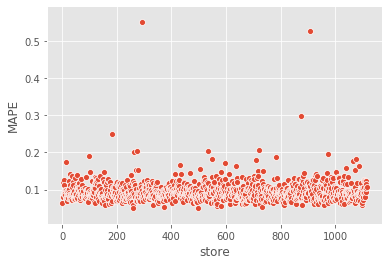

In [118]:
sns.scatterplot(x='store', y='MAPE', data=df_2);

## 11.2. Total Performance

In [119]:
df_3 = df_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'} )
df_3['Values'] = df_3['Values'].map('R${:,.2f}'.format)
display(df_3)

,Scenario,Values
0,predictions,"R$283,861,052.14"
1,worst_scenario,"R$283,124,045.50"
2,best_scenario,"R$284,598,058.79"


## 11.3. Machine Learning Performance

In [120]:
df_traduction['error'] = df_traduction['sales'] - df_traduction['predictions']
df_traduction['error_rate'] = df_traduction['predictions'] / df_traduction['sales']

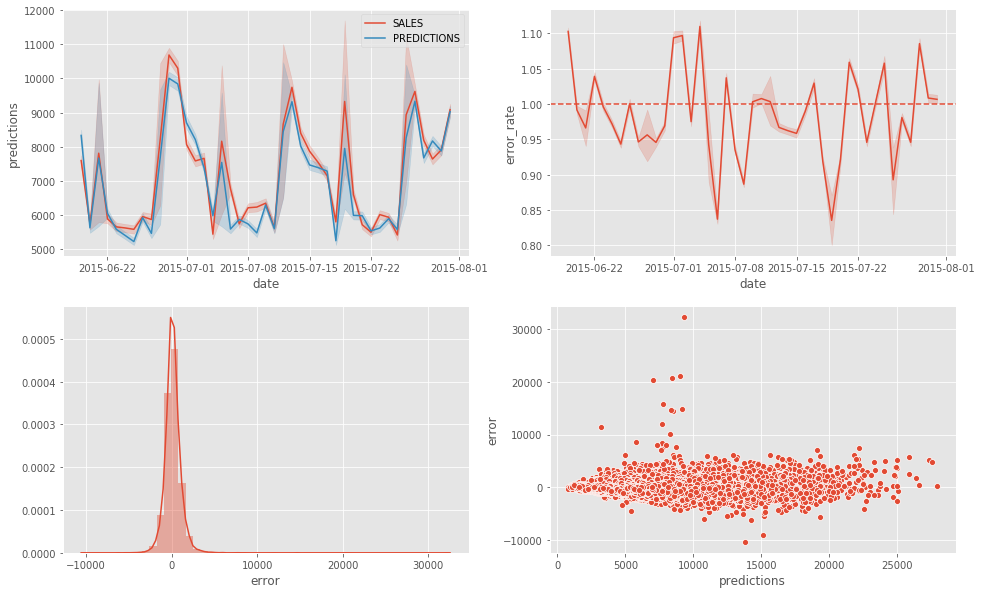

In [121]:
plt.figure(figsize=(16, 10))
plt.subplot( 2, 2, 1 )
sns.lineplot(x='date', y='sales', data=df_traduction, label='SALES')
sns.lineplot(x='date', y='predictions', data=df_traduction, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot(x='date', y='error_rate', data=df_traduction)
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot(df_traduction['error'])

plt.subplot( 2, 2, 4 )
sns.scatterplot(df_traduction['predictions'], df_traduction['error']);

The predictions have low errors, there are some outliers between about 5,000 and 10,000 of predictions. But, they're next to 0 in almost all of the cases. So, that's a good model!

# 12. API TESTER
---

After I've created the `Rossmann.py` and `handler.py` files, we can make the predictions of the test dataset from Kaggle.

Obs. 1: `Rossmann.py` make all the data preprocess for data model input, and `handler.py` helps the modelling flow.

Obs. 2: To run this section, we have to go to `api` folder and run the handler: `python handler.py`

In [122]:
# Loading test data
test = pd.read_csv('data/raw/test.csv')

In [123]:
# Merge test + store datasets
df_test = test.merge(df_store, on='Store', how='left')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([12, 22, 24])]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

df_test.drop('Id', axis=1, inplace=True)

In [124]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [125]:
# API call
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [126]:
# Predict
df_pred = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [127]:
df_pred.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Prediction
0,12,4,2015-09-17,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6292.336914
1,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4547.601074
2,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",7318.179199
3,12,3,2015-09-16,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct",6968.551270
4,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4488.956543


In [128]:
# Predictions by store
store_pred = df_pred.groupby('Store', as_index=False)['Prediction'].sum()

In [129]:
for i in range(len(store_pred)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks.'.format(
        store_pred.loc[i, 'Store'], store_pred.loc[i, 'Prediction']))

Store Number 12 will sell $232,577.42 in the next 6 weeks.
Store Number 22 will sell $178,960.07 in the next 6 weeks.
Store Number 24 will sell $300,138.94 in the next 6 weeks.
